# Setup
(No need to change anything)

In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-qbvoyg0l
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-qbvoyg0l
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit ce82675a8e89b6d5e6229a89620c843c794f3b04
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.5 MB/s eta 0:00:00
     

In [2]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [3]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [4]:
torch.set_grad_enabled(False)

## Load Model

In [5]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


# get preds fn

In [6]:
def remove_batch_dim(
    tensor: Float[torch.Tensor, "1 ..."]
) -> Float[torch.Tensor, "..."]:
    """
    Removes the first dimension of a tensor if it is size 1, otherwise returns the tensor unchanged
    """
    if tensor.shape[0] == 1:
        return tensor.squeeze(0)
    else:
        return tensor

In [7]:
def get_top_preds(
    prompt: str,
    answer: str,
    model,  # Can't give type hint due to circular imports
    prepend_space_to_answer: Optional[bool] = True,
    print_details: Optional[bool] = True,
    prepend_bos: Optional[bool] = True, # key change
    top_k: Optional[int] = 10,
) -> None:
    """
    Args:
        prompt:
            The prompt string, e.g. "Why did the elephant cross the".
        answer:
            The answer, e.g. "road". Note that if you set prepend_space_to_answer to False, you need
            to think about if you have a space before the answer here (as e.g. in this example the
            answer may really be " road" if the prompt ends without a trailing space).
        model:
            The model.
        prepend_space_to_answer:
            Whether or not to prepend a space to the answer. Note this will only ever prepend a
            space if the answer doesn't already start with one.
        print_details:
            Print the prompt (as a string but broken up by token), answer and top k tokens (all
            with logit, rank and probability).
        prepend_bos:
            Overrides self.cfg.default_prepend_bos if set. Whether to prepend
            the BOS token to the input (applicable when input is a string). Models generally learn
            to use the BOS token as a resting place for attention heads (i.e. a way for them to be
            "turned off"). This therefore often improves performance slightly.
        top_k:
            Top k tokens to print details of (when print_details is set to True).

    Returns:
        None (just prints the results directly).
    """
    if prepend_space_to_answer and not answer.startswith(" "):
        answer = " " + answer
    # GPT-2 often treats the first token weirdly, so lets give it a resting position
    prompt_tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
    answer_tokens = model.to_tokens(answer, prepend_bos=False)
    tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)
    prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)
    answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
    prompt_length = len(prompt_str_tokens)
    answer_length = len(answer_str_tokens)
    # if print_details:
    #     print("Tokenized prompt:", prompt_str_tokens)
    #     print("Tokenized answer:", answer_str_tokens)
    logits = remove_batch_dim(model(tokens))  # key change
    # logits = remove_batch_dim(model(prompt_tokens))  # key change
    probs = logits.softmax(dim=-1)

    # key changes
    # logits = logits[0]
    # probs = probs[0]

    answer_ranks = []

    # from end of input to how long answer is (if answer is 1 token, this is just 1)
    for index in range(prompt_length, prompt_length + answer_length):
        answer_token = tokens[0, index]
        answer_str_token = answer_str_tokens[index - prompt_length]
        # Offset by 1 because models predict the NEXT token
        token_probs = probs[index - 1]
        sorted_token_probs, sorted_token_values = token_probs.sort(descending=True)
        # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
        correct_rank = torch.arange(len(sorted_token_values))[
            (sorted_token_values == answer_token).cpu()
        ].item()
        answer_ranks.append((answer_str_token, correct_rank))
        # if print_details:
        #     # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
        #     # rprint gives rich text printing
        #     print(
        #         f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
        #     )
        #     for i in range(top_k):
        #         print(
        #             f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
        #         )
    # print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

    return logits[index-1, sorted_token_values[:top_k]], sorted_token_probs[:top_k], [model.to_string(tok) for tok in sorted_token_values[:top_k]]

In [8]:
def get_top_preds_moredata(
    prompt: str,
    answer: str,
    model,  # Can't give type hint due to circular imports
    incor: str,
    prepend_space_to_answer: Optional[bool] = True,
    print_details: Optional[bool] = True,
    prepend_bos: Optional[bool] = True, # key change
    top_k: Optional[int] = 10,
):
    """
    Args:
        prompt:
            The prompt string, e.g. "Why did the elephant cross the".
        answer:
            The answer, e.g. "road". Note that if you set prepend_space_to_answer to False, you need
            to think about if you have a space before the answer here (as e.g. in this example the
            answer may really be " road" if the prompt ends without a trailing space).
        model:
            The model.
        prepend_space_to_answer:
            Whether or not to prepend a space to the answer. Note this will only ever prepend a
            space if the answer doesn't already start with one.
        print_details:
            Print the prompt (as a string but broken up by token), answer and top k tokens (all
            with logit, rank and probability).
        prepend_bos:
            Overrides self.cfg.default_prepend_bos if set. Whether to prepend
            the BOS token to the input (applicable when input is a string). Models generally learn
            to use the BOS token as a resting place for attention heads (i.e. a way for them to be
            "turned off"). This therefore often improves performance slightly.
        top_k:
            Top k tokens to print details of (when print_details is set to True).

    Returns:
        None (just prints the results directly).
    """
    if prepend_space_to_answer and not answer.startswith(" "):
        answer = " " + answer
    # GPT-2 often treats the first token weirdly, so lets give it a resting position
    prompt_tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
    answer_tokens = model.to_tokens(answer, prepend_bos=False)
    tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)
    prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)
    answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
    prompt_length = len(prompt_str_tokens)
    answer_length = len(answer_str_tokens)
    # if print_details:
    #     print("Tokenized prompt:", prompt_str_tokens)
    #     print("Tokenized answer:", answer_str_tokens)
    logits = remove_batch_dim(model(tokens))  # key change
    # logits = remove_batch_dim(model(prompt_tokens))  # key change
    probs = logits.softmax(dim=-1)

    # key changes
    # logits = logits[0]
    # probs = probs[0]

    answer_ranks = []

    # from end of input to how long answer is (if answer is 1 token, this is just 1)
    for index in range(prompt_length, prompt_length + answer_length):
        answer_token = tokens[0, index]
        answer_str_token = answer_str_tokens[index - prompt_length]
        # Offset by 1 because models predict the NEXT token
        token_probs = probs[index - 1]
        sorted_token_probs, sorted_token_values = token_probs.sort(descending=True)
        # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
        correct_rank = torch.arange(len(sorted_token_values))[
            (sorted_token_values == answer_token).cpu()
        ].item()
        answer_ranks.append((answer_str_token, correct_rank))
        # if print_details:
        #     # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
        #     # rprint gives rich text printing
        #     print(
        #         f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
        #     )
        #     for i in range(top_k):
        #         print(
        #             f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
        #         )
    # print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

    k = top_k
    while k < 500:
        toks = [model.to_string(tok) for tok in sorted_token_values[:k]]
        if incor in toks:
            incor_ind = toks.index(incor)
            break
        else:
            k += 50
            # print(k)

    if k < 500:
        return logits[index-1, sorted_token_values[:k]], sorted_token_probs[:k], toks, incor_ind
    else:
        return [], [], [], 'cont'

# Numeric

In [90]:
example_prompt = "10000 10001 10002 10003"
example_answer = " 10004"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '10000', ' 100', '01', ' 1000', '2', ' 1000', '3']
Tokenized answer: [' 1000', '4']


Performance on answer token:
Rank: 0        Logit: 18.97 Prob: 70.11% Token: | 1000|

Top 0th token. Logit: 18.97 Prob: 70.11% Token: | 1000|
Top 1th token. Logit: 17.40 Prob: 14.66% Token: | 100|
Top 2th token. Logit: 15.69 Prob:  2.66% Token: | 10000|
Top 3th token. Logit: 15.21 Prob:  1.64% Token: | 10|
Top 4th token. Logit: 15.05 Prob:  1.40% Token: | 2000|
Top 5th token. Logit: 14.17 Prob:  0.58% Token: |
|
Top 6th token. Logit: 14.10 Prob:  0.54% Token: | 0|
Top 7th token. Logit: 13.77 Prob:  0.39% Token: | 101|
Top 8th token. Logit: 13.69 Prob:  0.36% Token: | 1100|
Top 9th token. Logit: 13.61 Prob:  0.33% Token: | 9|


Performance on answer token:
Rank: 0        Logit: 22.34 Prob: 99.51% Token: |4|

Top 0th token. Logit: 22.34 Prob: 99.51% Token: |4|
Top 1th token. Logit: 16.40 Prob:  0.26% Token: |5|
Top 2th token. Logit: 15.23 Prob:  0.08% Token: |6|
Top 3th token. Logit: 13.98 Prob:  0.02% Token: |44|
Top 4th token. Logit: 13.83 Prob:  0.02% Token: |8|
Top 5th token. Logit: 13.26 Prob:  0.01% Token: | 4|
Top 6th token. Logit: 12.16 Prob:  0.00% Token: |3|
Top 7th token. Logit: 12.08 Prob:  0.00% Token: |64|
Top 8th token. Logit: 12.07 Prob:  0.00% Token: |54|
Top 9th token. Logit: 12.01 Prob:  0.00% Token: |1|


Ranks of the answer tokens: [(' 1000', 0), ('4', 0)]

In [91]:
example_prompt = "1000 1001 1002 1003"
example_answer = " 1004"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '1000', ' 100', '1', ' 100', '2', ' 100', '3']
Tokenized answer: [' 100', '4']


Performance on answer token:
Rank: 0        Logit: 19.33 Prob: 89.36% Token: | 100|

Top 0th token. Logit: 19.33 Prob: 89.36% Token: | 100|
Top 1th token. Logit: 15.58 Prob:  2.09% Token: | 1000|
Top 2th token. Logit: 15.27 Prob:  1.53% Token: | 10|
Top 3th token. Logit: 14.69 Prob:  0.86% Token: | 101|
Top 4th token. Logit: 14.58 Prob:  0.77% Token: |
|
Top 5th token. Logit: 13.91 Prob:  0.40% Token: | 0|
Top 6th token. Logit: 13.79 Prob:  0.35% Token: | 10000|
Top 7th token. Logit: 13.57 Prob:  0.28% Token: | 2000|
Top 8th token. Logit: 13.43 Prob:  0.25% Token: | 1|
Top 9th token. Logit: 13.19 Prob:  0.19% Token: | 9|


Performance on answer token:
Rank: 0        Logit: 25.97 Prob: 99.93% Token: |4|

Top 0th token. Logit: 25.97 Prob: 99.93% Token: |4|
Top 1th token. Logit: 17.07 Prob:  0.01% Token: |6|
Top 2th token. Logit: 17.06 Prob:  0.01% Token: |5|
Top 3th token. Logit: 16.60 Prob:  0.01% Token: |44|
Top 4th token. Logit: 16.06 Prob:  0.00% Token: |8|
Top 5th token. Logit: 15.61 Prob:  0.00% Token: |14|
Top 6th token. Logit: 15.52 Prob:  0.00% Token: |64|
Top 7th token. Logit: 15.34 Prob:  0.00% Token: |1|
Top 8th token. Logit: 14.90 Prob:  0.00% Token: |34|
Top 9th token. Logit: 14.83 Prob:  0.00% Token: |54|


Ranks of the answer tokens: [(' 100', 0), ('4', 0)]

In [93]:
example_prompt = "1000 1001 1002 1003 100"
example_answer = " 4"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '1000', ' 100', '1', ' 100', '2', ' 100', '3', ' 100']
Tokenized answer: [' 4']


Performance on answer token:
Rank: 11       Logit: 14.63 Prob:  0.00% Token: | 4|

Top 0th token. Logit: 25.97 Prob: 99.93% Token: |4|
Top 1th token. Logit: 17.07 Prob:  0.01% Token: |6|
Top 2th token. Logit: 17.06 Prob:  0.01% Token: |5|
Top 3th token. Logit: 16.60 Prob:  0.01% Token: |44|
Top 4th token. Logit: 16.06 Prob:  0.00% Token: |8|
Top 5th token. Logit: 15.61 Prob:  0.00% Token: |14|
Top 6th token. Logit: 15.52 Prob:  0.00% Token: |64|
Top 7th token. Logit: 15.34 Prob:  0.00% Token: |1|
Top 8th token. Logit: 14.90 Prob:  0.00% Token: |34|
Top 9th token. Logit: 14.83 Prob:  0.00% Token: |54|


Ranks of the answer tokens: [(' 4', 11)]

In [94]:
example_prompt = "1020 1021 1022 1023"
example_answer = " 4"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '10', '20', ' 10', '21', ' 10', '22', ' 10', '23']
Tokenized answer: [' 4']


Performance on answer token:
Rank: 413      Logit:  6.40 Prob:  0.00% Token: | 4|

Top 0th token. Logit: 16.99 Prob: 76.50% Token: | 10|
Top 1th token. Logit: 15.09 Prob: 11.37% Token: | 1024|
Top 2th token. Logit: 12.66 Prob:  1.00% Token: | 1050|
Top 3th token. Logit: 12.42 Prob:  0.79% Token: | 110|
Top 4th token. Logit: 12.42 Prob:  0.79% Token: |
|
Top 5th token. Logit: 12.29 Prob:  0.70% Token: | 100|
Top 6th token. Logit: 11.99 Prob:  0.51% Token: | 1070|
Top 7th token. Logit: 11.88 Prob:  0.46% Token: | 1080|
Top 8th token. Logit: 11.73 Prob:  0.40% Token: | 101|
Top 9th token. Logit: 11.56 Prob:  0.33% Token: | 2010|


Ranks of the answer tokens: [(' 4', 413)]

In [96]:
example_prompt = "520 521 522 523"
example_answer = " 524"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '520', ' 5', '21', ' 5', '22', ' 5', '23']
Tokenized answer: [' 5', '24']


Performance on answer token:
Rank: 0        Logit: 17.56 Prob: 82.09% Token: | 5|

Top 0th token. Logit: 17.56 Prob: 82.09% Token: | 5|
Top 1th token. Logit: 13.83 Prob:  1.98% Token: | 525|
Top 2th token. Logit: 13.75 Prob:  1.83% Token: | 520|
Top 3th token. Logit: 13.60 Prob:  1.57% Token: | 530|
Top 4th token. Logit: 13.16 Prob:  1.01% Token: | 540|
Top 5th token. Logit: 13.13 Prob:  0.98% Token: |
|
Top 6th token. Logit: 12.88 Prob:  0.77% Token: | 555|
Top 7th token. Logit: 12.53 Prob:  0.54% Token: | 529|
Top 8th token. Logit: 12.48 Prob:  0.51% Token: | 550|
Top 9th token. Logit: 12.29 Prob:  0.42% Token: | 512|


Performance on answer token:
Rank: 0        Logit: 27.23 Prob: 99.24% Token: |24|

Top 0th token. Logit: 27.23 Prob: 99.24% Token: |24|
Top 1th token. Logit: 21.58 Prob:  0.35% Token: |26|
Top 2th token. Logit: 20.24 Prob:  0.09% Token: |25|
Top 3th token. Logit: 20.22 Prob:  0.09% Token: |34|
Top 4th token. Logit: 20.21 Prob:  0.09% Token: |23|
Top 5th token. Logit: 18.98 Prob:  0.03% Token: |44|
Top 6th token. Logit: 18.79 Prob:  0.02% Token: |28|
Top 7th token. Logit: 18.73 Prob:  0.02% Token: |22|
Top 8th token. Logit: 18.41 Prob:  0.01% Token: | 24|
Top 9th token. Logit: 17.67 Prob:  0.01% Token: |27|


Ranks of the answer tokens: [(' 5', 0), ('24', 0)]

In [97]:
example_prompt = "420 421 422 423"
example_answer = " 424"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '420', ' 421', ' 422', ' 423']
Tokenized answer: [' 424']


Performance on answer token:
Rank: 0        Logit: 18.04 Prob: 76.13% Token: | 424|

Top 0th token. Logit: 18.04 Prob: 76.13% Token: | 424|
Top 1th token. Logit: 15.75 Prob:  7.69% Token: | 4|
Top 2th token. Logit: 14.17 Prob:  1.59% Token: | 426|
Top 3th token. Logit: 14.16 Prob:  1.57% Token: | 425|
Top 4th token. Logit: 13.99 Prob:  1.33% Token: | 422|
Top 5th token. Logit: 13.88 Prob:  1.18% Token: | 444|
Top 6th token. Logit: 13.80 Prob:  1.10% Token: | 423|
Top 7th token. Logit: 13.24 Prob:  0.63% Token: |
|
Top 8th token. Logit: 12.91 Prob:  0.45% Token: | 429|
Top 9th token. Logit: 12.77 Prob:  0.39% Token: | 428|


Ranks of the answer tokens: [(' 424', 0)]

In [98]:
example_prompt = "500 501 502 503"
example_answer = " 504"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '500', ' 501', ' 502', ' 503']
Tokenized answer: [' 504']


Performance on answer token:
Rank: 0        Logit: 20.48 Prob: 97.06% Token: | 504|

Top 0th token. Logit: 20.48 Prob: 97.06% Token: | 504|
Top 1th token. Logit: 15.50 Prob:  0.66% Token: | 4|
Top 2th token. Logit: 15.30 Prob:  0.54% Token: |
|
Top 3th token. Logit: 13.83 Prob:  0.13% Token: | 04|
Top 4th token. Logit: 12.82 Prob:  0.05% Token: | 404|
Top 5th token. Logit: 12.65 Prob:  0.04% Token: | Web|
Top 6th token. Logit: 12.55 Prob:  0.03% Token: | 505|
Top 7th token. Logit: 12.52 Prob:  0.03% Token: | U|
Top 8th token. Logit: 12.48 Prob:  0.03% Token: | (|
Top 9th token. Logit: 12.40 Prob:  0.03% Token: | -|


Ranks of the answer tokens: [(' 504', 0)]

In [99]:
example_prompt = "590 591 592 593"
example_answer = " 594"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '590', ' 5', '91', ' 5', '92', ' 5', '93']
Tokenized answer: [' 5', '94']


Performance on answer token:
Rank: 0        Logit: 18.11 Prob: 86.14% Token: | 5|

Top 0th token. Logit: 18.11 Prob: 86.14% Token: | 5|
Top 1th token. Logit: 14.62 Prob:  2.61% Token: | 6|
Top 2th token. Logit: 13.87 Prob:  1.23% Token: |
|
Top 3th token. Logit: 13.08 Prob:  0.56% Token: | 580|
Top 4th token. Logit: 12.79 Prob:  0.42% Token: | 59|
Top 5th token. Logit: 12.62 Prob:  0.35% Token: | 570|
Top 6th token. Logit: 12.51 Prob:  0.32% Token: | 4|
Top 7th token. Logit: 12.43 Prob:  0.29% Token: | 530|
Top 8th token. Logit: 12.40 Prob:  0.29% Token: | 600|
Top 9th token. Logit: 12.34 Prob:  0.27% Token: | 560|


Performance on answer token:
Rank: 0        Logit: 31.24 Prob: 99.86% Token: |94|

Top 0th token. Logit: 31.24 Prob: 99.86% Token: |94|
Top 1th token. Logit: 23.46 Prob:  0.04% Token: |44|
Top 2th token. Logit: 22.87 Prob:  0.02% Token: |74|
Top 3th token. Logit: 22.58 Prob:  0.02% Token: |54|
Top 4th token. Logit: 22.48 Prob:  0.02% Token: |95|
Top 5th token. Logit: 22.14 Prob:  0.01% Token: |24|
Top 6th token. Logit: 21.56 Prob:  0.01% Token: |84|
Top 7th token. Logit: 21.50 Prob:  0.01% Token: |64|
Top 8th token. Logit: 21.37 Prob:  0.01% Token: |34|
Top 9th token. Logit: 21.00 Prob:  0.00% Token: |96|


Ranks of the answer tokens: [(' 5', 0), ('94', 0)]

In [101]:
example_prompt = "I, II, III, IV, V,"
example_answer = " VI"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'I', ',', ' II', ',', ' III', ',', ' IV', ',', ' V', ',']
Tokenized answer: [' VI']


Performance on answer token:
Rank: 0        Logit: 19.24 Prob: 94.39% Token: | VI|

Top 0th token. Logit: 19.24 Prob: 94.39% Token: | VI|
Top 1th token. Logit: 14.98 Prob:  1.33% Token: | and|
Top 2th token. Logit: 14.85 Prob:  1.16% Token: | V|
Top 3th token. Logit: 13.35 Prob:  0.26% Token: | I|
Top 4th token. Logit: 13.18 Prob:  0.22% Token: | VII|
Top 5th token. Logit: 13.06 Prob:  0.19% Token: | III|
Top 6th token. Logit: 12.98 Prob:  0.18% Token: | X|
Top 7th token. Logit: 12.93 Prob:  0.17% Token: | VIII|
Top 8th token. Logit: 12.77 Prob:  0.15% Token: | XX|
Top 9th token. Logit: 12.59 Prob:  0.12% Token: | vi|


Ranks of the answer tokens: [(' VI', 0)]

In [102]:
example_prompt = "eighth nineth tenth eleventh"
example_answer = " twelfth"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'e', 'ighth', ' nin', 'eth', ' tenth', ' ele', 'venth']
Tokenized answer: [' tw', 'elfth']


Performance on answer token:
Rank: 0        Logit: 14.69 Prob: 24.77% Token: | tw|

Top 0th token. Logit: 14.69 Prob: 24.77% Token: | tw|
Top 1th token. Logit: 14.39 Prob: 18.36% Token: | ele|
Top 2th token. Logit: 12.79 Prob:  3.69% Token: | th|
Top 3th token. Logit: 12.42 Prob:  2.57% Token: |
|
Top 4th token. Logit: 12.40 Prob:  2.51% Token: | ten|
Top 5th token. Logit: 12.36 Prob:  2.40% Token: | f|
Top 6th token. Logit: 11.91 Prob:  1.54% Token: | n|
Top 7th token. Logit: 11.87 Prob:  1.49% Token: | tenth|
Top 8th token. Logit: 11.63 Prob:  1.17% Token: | twenty|
Top 9th token. Logit: 11.60 Prob:  1.13% Token: | nin|


Performance on answer token:
Rank: 0        Logit: 25.93 Prob: 98.54% Token: |elfth|

Top 0th token. Logit: 25.93 Prob: 98.54% Token: |elfth|
Top 1th token. Logit: 21.48 Prob:  1.15% Token: |ent|
Top 2th token. Logit: 17.99 Prob:  0.03% Token: |en|
Top 3th token. Logit: 17.77 Prob:  0.03% Token: |e|
Top 4th token. Logit: 17.55 Prob:  0.02% Token: |el|
Top 5th token. Logit: 17.51 Prob:  0.02% Token: |ig|
Top 6th token. Logit: 17.16 Prob:  0.02% Token: |elve|
Top 7th token. Logit: 17.03 Prob:  0.01% Token: |ir|
Top 8th token. Logit: 16.93 Prob:  0.01% Token: |ixt|
Top 9th token. Logit: 16.92 Prob:  0.01% Token: |ence|


Ranks of the answer tokens: [(' tw', 0), ('elfth', 0)]

# find templates

In [20]:
example_prompt = "Adam 1 John 2 Claire 3 Eve 4 Dan"
example_answer = " 5"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Adam', ' 1', ' John', ' 2', ' Claire', ' 3', ' Eve', ' 4', ' Dan']
Tokenized answer: [' 5']


Performance on answer token:
Rank: 0        Logit: 18.91 Prob: 89.71% Token: | 5|

Top 0th token. Logit: 18.91 Prob: 89.71% Token: | 5|
Top 1th token. Logit: 14.60 Prob:  1.20% Token: | 4|
Top 2th token. Logit: 14.55 Prob:  1.14% Token: |ie|
Top 3th token. Logit: 14.19 Prob:  0.80% Token: | 1|
Top 4th token. Logit: 13.97 Prob:  0.64% Token: |
|
Top 5th token. Logit: 13.65 Prob:  0.47% Token: | 6|
Top 6th token. Logit: 13.58 Prob:  0.43% Token: |ay|
Top 7th token. Logit: 13.36 Prob:  0.35% Token: |ica|
Top 8th token. Logit: 13.33 Prob:  0.34% Token: |ner|
Top 9th token. Logit: 13.22 Prob:  0.30% Token: |ai|


Ranks of the answer tokens: [(' 5', 0)]

In [21]:
example_prompt = "1 dog 2 fish 3 pig 4 cat"
example_answer = " 5"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '1', ' dog', ' 2', ' fish', ' 3', ' pig', ' 4', ' cat']
Tokenized answer: [' 5']


Performance on answer token:
Rank: 0        Logit: 18.27 Prob: 92.24% Token: | 5|

Top 0th token. Logit: 18.27 Prob: 92.24% Token: | 5|
Top 1th token. Logit: 14.26 Prob:  1.67% Token: |
|
Top 2th token. Logit: 14.07 Prob:  1.39% Token: | 4|
Top 3th token. Logit: 13.27 Prob:  0.62% Token: | 1|
Top 4th token. Logit: 13.18 Prob:  0.57% Token: |fish|
Top 5th token. Logit: 12.72 Prob:  0.36% Token: | 10|
Top 6th token. Logit: 12.71 Prob:  0.36% Token: | 6|
Top 7th token. Logit: 12.27 Prob:  0.23% Token: | 50|
Top 8th token. Logit: 11.91 Prob:  0.16% Token: | 3|
Top 9th token. Logit: 11.76 Prob:  0.14% Token: |5|


Ranks of the answer tokens: [(' 5', 0)]

In [31]:
example_prompt = "January dog February fish March pig April cat"
example_answer = " 5"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'January', ' dog', ' February', ' fish', ' March', ' pig', ' April', ' cat']
Tokenized answer: [' 5']


Performance on answer token:
Rank: 13       Logit: 11.22 Prob:  0.09% Token: | 5|

Top 0th token. Logit: 18.13 Prob: 86.04% Token: | May|
Top 1th token. Logit: 15.23 Prob:  4.69% Token: | April|
Top 2th token. Logit: 14.13 Prob:  1.57% Token: | March|
Top 3th token. Logit: 13.88 Prob:  1.22% Token: |
|
Top 4th token. Logit: 13.75 Prob:  1.08% Token: | June|
Top 5th token. Logit: 13.30 Prob:  0.68% Token: | July|
Top 6th token. Logit: 12.45 Prob:  0.29% Token: | September|
Top 7th token. Logit: 11.81 Prob:  0.15% Token: | February|
Top 8th token. Logit: 11.81 Prob:  0.15% Token: | October|
Top 9th token. Logit: 11.58 Prob:  0.12% Token: | November|


Ranks of the answer tokens: [(' 5', 13)]

In [33]:
example_prompt = "July dog August fish September pig November cat"
example_answer = " December"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'July', ' dog', ' August', ' fish', ' September', ' pig', ' November', ' cat']
Tokenized answer: [' December']


Performance on answer token:
Rank: 0        Logit: 13.33 Prob: 25.05% Token: | December|

Top 0th token. Logit: 13.33 Prob: 25.05% Token: | December|
Top 1th token. Logit: 12.04 Prob:  6.90% Token: | February|
Top 2th token. Logit: 11.92 Prob:  6.10% Token: |
|
Top 3th token. Logit: 11.41 Prob:  3.69% Token: | October|
Top 4th token. Logit: 11.18 Prob:  2.93% Token: |fish|
Top 5th token. Logit: 11.01 Prob:  2.46% Token: | November|
Top 6th token. Logit: 10.95 Prob:  2.32% Token: | May|
Top 7th token. Logit: 10.80 Prob:  2.00% Token: | April|
Top 8th token. Logit: 10.80 Prob:  2.00% Token: | August|
Top 9th token. Logit: 10.72 Prob:  1.84% Token: | June|


Ranks of the answer tokens: [(' December', 0)]

In [23]:
example_prompt = "1 fish 2 dog 3 pigs 4 cats"
example_answer = " 5"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '1', ' fish', ' 2', ' dog', ' 3', ' pigs', ' 4', ' cats']
Tokenized answer: [' 5']


Performance on answer token:
Rank: 0        Logit: 17.67 Prob: 85.31% Token: | 5|

Top 0th token. Logit: 17.67 Prob: 85.31% Token: | 5|
Top 1th token. Logit: 14.32 Prob:  2.99% Token: | 4|
Top 2th token. Logit: 14.03 Prob:  2.23% Token: | 1|
Top 3th token. Logit: 13.99 Prob:  2.15% Token: |
|
Top 4th token. Logit: 13.22 Prob:  1.00% Token: | 6|
Top 5th token. Logit: 12.82 Prob:  0.67% Token: | 3|
Top 6th token. Logit: 12.76 Prob:  0.63% Token: | 2|
Top 7th token. Logit: 12.60 Prob:  0.54% Token: | 10|
Top 8th token. Logit: 12.13 Prob:  0.33% Token: | 50|
Top 9th token. Logit: 11.44 Prob:  0.17% Token: | 15|


Ranks of the answer tokens: [(' 5', 0)]

In [ ]:
example_prompt = "1 fish 2 dog 3 pigs 4 cats"
example_answer = " 5"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

In [22]:
example_prompt = "1 apple 2 oranges 3 bananas 4 pears"
example_answer = " 5"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '1', ' apple', ' 2', ' oranges', ' 3', ' bananas', ' 4', ' p', 'ears']
Tokenized answer: [' 5']


Performance on answer token:
Rank: 0        Logit: 16.48 Prob: 31.60% Token: | 5|

Top 0th token. Logit: 16.48 Prob: 31.60% Token: | 5|
Top 1th token. Logit: 16.02 Prob: 19.86% Token: | 1|
Top 2th token. Logit: 15.35 Prob: 10.12% Token: | 4|
Top 3th token. Logit: 15.15 Prob:  8.35% Token: | 2|
Top 4th token. Logit: 14.65 Prob:  5.06% Token: |
|
Top 5th token. Logit: 14.58 Prob:  4.73% Token: | 3|
Top 6th token. Logit: 14.20 Prob:  3.22% Token: | 6|
Top 7th token. Logit: 13.10 Prob:  1.08% Token: | 10|
Top 8th token. Logit: 13.02 Prob:  0.99% Token: | 8|
Top 9th token. Logit: 12.86 Prob:  0.84% Token: | ½|


Ranks of the answer tokens: [(' 5', 0)]

# random words same interval and keep on prob

In [ ]:
# https://bobbyhadz.com/blog/python-generate-random-word
import random
import requests

def get_list_of_words():
    response = requests.get(
        'https://www.mit.edu/~ecprice/wordlist.10000',
        timeout=10
    )

    string_of_words = response.content.decode('utf-8')

    list_of_words = string_of_words.splitlines()

    return list_of_words

words = get_list_of_words()
print(len(words))

random_word = random.choice(words)
print(random_word)  # 👉️ zoo

10000
relationship


In [ ]:
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
words = filter_to_single_token(words)
len(words)

3266

In [87]:
def generate_prompts_list(x, y, words):
    prompts_list = []
    for i in range(x, y):
        # for j in range(20):
        for j in range(30):
        # for j in range(2):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': str(i),
                'S2': str(i+1),
                'S3': str(i+2),
                'S4': str(i+3),
                'corr': f" {i+4}",
                'incorr': f" {i+3}",
                'text': f"{rand_words[0]} {i} {rand_words[1]} {i+1} {rand_words[2]} {i+2} {rand_words[3]} {i+3} {rand_words[4]}",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 501, words)

In [88]:
logit_diffs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    if toks[0] == answer and probs[0] > 0.5 and probs[1] < 0.1:
        # print(f"{prompt} -> {answer}")
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 10000:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: ignored

In [89]:
good_prompts

[{'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'pick 1 historic 2 rack 3 affected 4 offensive'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'gay 1 alias 2 hist 3 bath 4 dollar'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'commercial 1 lib 2 bag 3 mind 4 white'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'sh 1 ian 2 fast 3 fat 4 inline'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'chan 1 un 2 trained 3 order 4 border'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'meaning 1 union 2 selling 3 journal 4 running'},
 {'S1': '2',
  'S2': '3',
  'S3': '4',
  'S4': '5',
  'corr': ' 6',
  'incorr': ' 5',
  'text': 'sum 2 mn 3 gently 4 ton 5 nuts'},
 {'S1': '2',
  'S2': '3',
  'S3': '4

In [73]:
probs

tensor([0.2480, 0.0632, 0.0353, 0.0323, 0.0261, 0.0229, 0.0219, 0.0202, 0.0172,
        0.0143], device='cuda:0')

Text(0.5, 1.0, 'Distribution of logit_diffs')

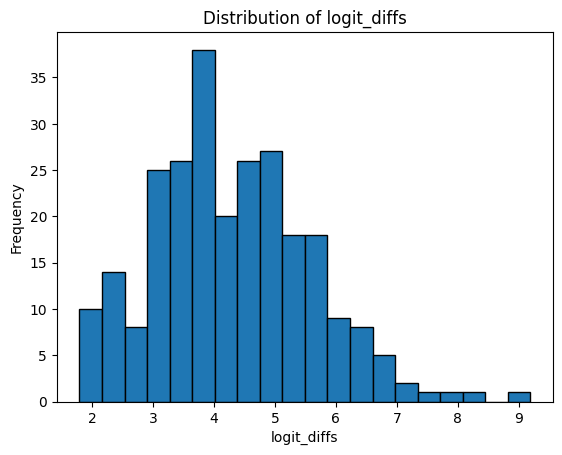

In [74]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('logit_diffs')
plt.ylabel('Frequency')
plt.title('Distribution of logit_diffs')

# random words same interval and keep on prob 1024 digits

In [9]:
# https://bobbyhadz.com/blog/python-generate-random-word
import random
import requests

def get_list_of_words():
    response = requests.get(
        'https://www.mit.edu/~ecprice/wordlist.10000',
        timeout=10
    )

    string_of_words = response.content.decode('utf-8')

    list_of_words = string_of_words.splitlines()

    return list_of_words

words = get_list_of_words()
print(len(words))

random_word = random.choice(words)
print(random_word)  # 👉️ zoo

10000
greatly


In [10]:
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
words = filter_to_single_token(words)
len(words)

3266

In [24]:
def generate_prompts_list(x, y, words):
    prompts_list = []
    for i in range(x, y):
        # for j in range(20):
        for j in range(1024):
        # for j in range(2):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': str(i),
                'S2': str(i+1),
                'S3': str(i+2),
                'S4': str(i+3),
                'corr': f" {i+4}",
                'incorr': f" {i+3}",
                'text': f"{rand_words[0]} {i} {rand_words[1]} {i+1} {rand_words[2]} {i+2} {rand_words[3]} {i+3} {rand_words[4]}",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 8, words)

In [26]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.7 and probs[1] < 0.1:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [19]:
example_prompt = "dash 2 image 3 join 4 random 5 via"
example_answer = " 6"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'dash', ' 2', ' image', ' 3', ' join', ' 4', ' random', ' 5', ' via']
Tokenized answer: [' 6']


Performance on answer token:
Rank: 5        Logit: 10.05 Prob:  1.56% Token: | 6|

Top 0th token. Logit: 10.52 Prob:  2.50% Token: | 4|
Top 1th token. Logit: 10.51 Prob:  2.48% Token: | 5|
Top 2th token. Logit: 10.25 Prob:  1.92% Token: | img|
Top 3th token. Logit: 10.18 Prob:  1.77% Token: | 3|
Top 4th token. Logit: 10.07 Prob:  1.59% Token: | image|
Top 5th token. Logit: 10.05 Prob:  1.56% Token: | 6|
Top 6th token. Logit: 10.04 Prob:  1.55% Token: | d|
Top 7th token. Logit:  9.98 Prob:  1.45% Token: | the|
Top 8th token. Logit:  9.92 Prob:  1.38% Token: | 1|
Top 9th token. Logit:  9.88 Prob:  1.31% Token: | a|


Ranks of the answer tokens: [(' 6', 5)]

In [27]:
len(good_prompts)

671

In [30]:
good_prompts

[{'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'bold 1 hello 2 cult 3 stud 4 sites'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'roll 1 correct 2 ya 3 bill 4 sale'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'nec 1 control 2 inn 3 lat 4 track'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'resident 1 intent 2 attach 3 bow 4 tones'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'biz 1 chen 2 drivers 3 strike 4 rule'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'hall 1 lease 2 pill 3 cats 4 cakes'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'efficiency 1 lock 2 quote 3 serious 4 fake'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  

In [29]:
all_probs

[tensor([0.8620, 0.0340, 0.0101, 0.0079, 0.0062, 0.0045, 0.0041, 0.0024, 0.0015,
         0.0014], device='cuda:0'),
 tensor([0.7104, 0.0244, 0.0170, 0.0078, 0.0073, 0.0059, 0.0046, 0.0045, 0.0042,
         0.0039], device='cuda:0'),
 tensor([0.7267, 0.0290, 0.0215, 0.0183, 0.0107, 0.0096, 0.0080, 0.0064, 0.0061,
         0.0044], device='cuda:0'),
 tensor([0.8786, 0.0118, 0.0112, 0.0042, 0.0040, 0.0039, 0.0036, 0.0032, 0.0030,
         0.0028], device='cuda:0'),
 tensor([0.8567, 0.0165, 0.0094, 0.0067, 0.0060, 0.0054, 0.0042, 0.0040, 0.0027,
         0.0022], device='cuda:0'),
 tensor([0.8661, 0.0230, 0.0130, 0.0107, 0.0095, 0.0078, 0.0037, 0.0033, 0.0032,
         0.0026], device='cuda:0'),
 tensor([0.7439, 0.0243, 0.0228, 0.0167, 0.0137, 0.0113, 0.0072, 0.0041, 0.0041,
         0.0040], device='cuda:0'),
 tensor([0.7396, 0.0214, 0.0180, 0.0092, 0.0075, 0.0044, 0.0043, 0.0039, 0.0037,
         0.0035], device='cuda:0'),
 tensor([9.4608e-01, 9.3257e-03, 4.7388e-03, 3.4819e-03, 2.0796e

Text(0.5, 1.0, 'Distribution of logit_diffs')

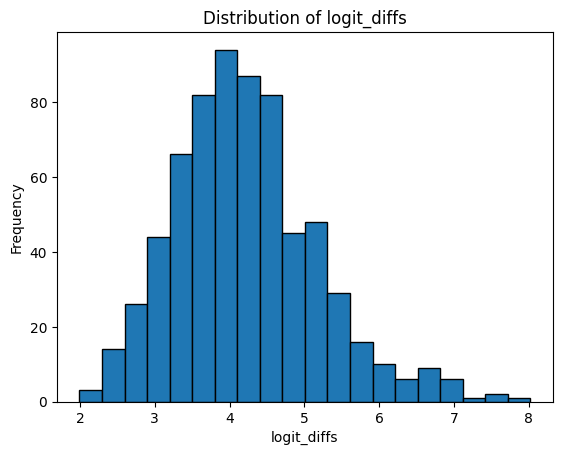

In [28]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('logit_diffs')
plt.ylabel('Frequency')
plt.title('Distribution of logit_diffs')

# random words same interval and over 50

In [ ]:
def generate_prompts_list(x, y, words):
    prompts_list = []
    for i in range(x, y):
        # for j in range(20):
        for j in range(1024):
        # for j in range(2):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': str(i),
                'S2': str(i+1),
                'S3': str(i+2),
                'S4': str(i+3),
                'corr': f" {i+4}",
                'incorr': f" {i+3}",
                'text': f"{rand_words[0]} {i} {rand_words[1]} {i+1} {rand_words[2]} {i+2} {rand_words[3]} {i+3} {rand_words[4]}",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 8, words)

In [34]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.5 and probs[1] < 0.1:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [37]:
import pickle

# Saving the dictionary to a file using pickle
with open('good_prompts_digits.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('good_prompts_digits.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'good_prompts_digits.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'bold 1 hello 2 cult 3 stud 4 sites'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'marriage 1 replace 2 banks 3 present 4 vote'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'formerly 1 multiple 2 civil 3 far 4 rb'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'scan 1 miss 2 tall 3 creator 4 relations'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'roll 1 correct 2 ya 3 bill 4 sale'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'nec 1 control 2 inn 3 lat 4 track'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'hunter 1 css 2 weapons 3 correct 4 perfect'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'resident 1 intent 2 attach 3 bow 4 t

Text(0.5, 1.0, 'Distribution of logit_diffs')

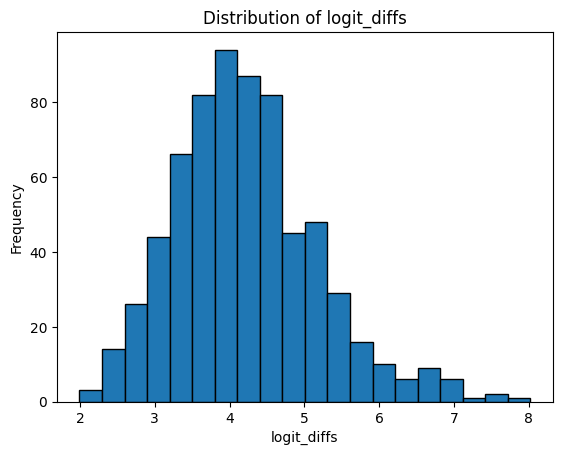

In [ ]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('logit_diffs')
plt.ylabel('Frequency')
plt.title('Distribution of logit_diffs')

# months random words same interval and over 50

In [43]:
def generate_prompts_list(x, y, words):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    prompts_list = []
    for i in range(x, y):
        # for j in range(20):
        for j in range(1024):
        # for j in range(2):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': months[i],
                'S2': months[i+1],
                'S3': months[i+2],
                'S4': months[i+3],
                'corr': f" {months[i+4]}",
                'incorr': f" {months[i+3]}",
                'text': f"{rand_words[0]} {months[i]} {rand_words[1]} {months[i+1]} {rand_words[2]} {months[i+2]} {rand_words[3]} {months[i+3]} {rand_words[4]}",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 8, words)

In [44]:
prompts_list[0]

{'S1': 'February',
 'S2': 'March',
 'S3': 'April',
 'S4': 'May',
 'corr': ' June',
 'incorr': ' May',
 'text': 'union February locks March amd April offset May bringing'}

In [46]:
example_prompt = prompts_list[0]['text']
example_answer = prompts_list[0]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'union', ' February', ' locks', ' March', ' amd', ' April', ' offset', ' May', ' bringing']
Tokenized answer: [' June']


Performance on answer token:
Rank: 5        Logit: 11.06 Prob:  2.76% Token: | June|

Top 0th token. Logit: 11.54 Prob:  4.46% Token: | in|
Top 1th token. Logit: 11.37 Prob:  3.77% Token: | April|
Top 2th token. Logit: 11.36 Prob:  3.73% Token: | May|
Top 3th token. Logit: 11.17 Prob:  3.09% Token: | back|
Top 4th token. Logit: 11.15 Prob:  3.04% Token: | up|
Top 5th token. Logit: 11.06 Prob:  2.76% Token: | June|
Top 6th token. Logit: 11.02 Prob:  2.65% Token: | the|
Top 7th token. Logit: 10.75 Prob:  2.03% Token: | out|
Top 8th token. Logit: 10.42 Prob:  1.45% Token: | July|
Top 9th token. Logit: 10.32 Prob:  1.32% Token: | on|


Ranks of the answer tokens: [(' June', 5)]

In [47]:
example_prompt = 'February Adam March Jane April Eve May Dan'
example_answer = prompts_list[0]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'February', ' Adam', ' March', ' Jane', ' April', ' Eve', ' May', ' Dan']
Tokenized answer: [' June']


Performance on answer token:
Rank: 5        Logit: 12.30 Prob:  1.59% Token: | June|

Top 0th token. Logit: 14.83 Prob: 19.95% Token: | May|
Top 1th token. Logit: 13.76 Prob:  6.82% Token: |ie|
Top 2th token. Logit: 13.75 Prob:  6.76% Token: |ica|
Top 3th token. Logit: 13.51 Prob:  5.33% Token: | April|
Top 4th token. Logit: 13.19 Prob:  3.86% Token: | August|
Top 5th token. Logit: 12.30 Prob:  1.59% Token: | June|
Top 6th token. Logit: 12.20 Prob:  1.44% Token: | March|
Top 7th token. Logit: 12.17 Prob:  1.39% Token: |
|
Top 8th token. Logit: 11.70 Prob:  0.87% Token: | September|
Top 9th token. Logit: 11.60 Prob:  0.79% Token: | July|


Ranks of the answer tokens: [(' June', 5)]

In [41]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    # if toks[0] == answer and probs[0] > 0.5 and probs[1] < 0.1:
    if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

KeyboardInterrupt: ignored

In [ ]:
import pickle

# Saving the dictionary to a file using pickle
with open('good_prompts_digits.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('good_prompts_digits.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'good_prompts_digits.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'bold 1 hello 2 cult 3 stud 4 sites'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'marriage 1 replace 2 banks 3 present 4 vote'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'formerly 1 multiple 2 civil 3 far 4 rb'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'scan 1 miss 2 tall 3 creator 4 relations'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'roll 1 correct 2 ya 3 bill 4 sale'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'nec 1 control 2 inn 3 lat 4 track'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'hunter 1 css 2 weapons 3 correct 4 perfect'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'resident 1 intent 2 attach 3 bow 4 t

Text(0.5, 1.0, 'Distribution of logit_diffs')

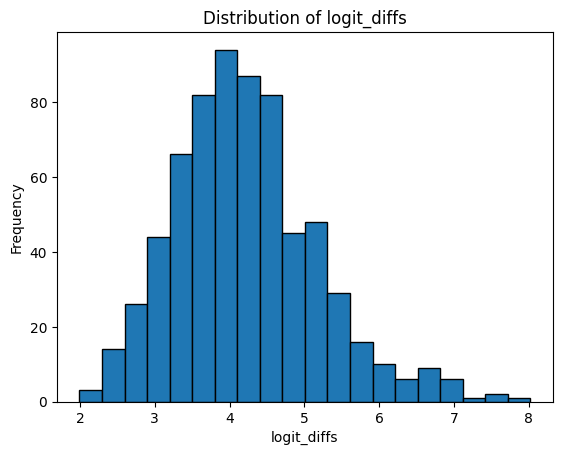

In [ ]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('logit_diffs')
plt.ylabel('Frequency')
plt.title('Distribution of logit_diffs')

# find templates for months

In [171]:
len(model.tokenizer.tokenize("made")) == 1

True

In [172]:
len(model.tokenizer.tokenize("born")) == 1

True

In [173]:
len(model.tokenizer.tokenize("bought")) == 1

False

In [174]:
len(model.tokenizer.tokenize("sold")) == 1

True

In [49]:
example_prompt = "February March April"
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'February', ' March', ' April']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 27.44 Prob: 99.77% Token: | May|

Top 0th token. Logit: 27.44 Prob: 99.77% Token: | May|
Top 1th token. Logit: 20.13 Prob:  0.07% Token: | 5|
Top 2th token. Logit: 19.65 Prob:  0.04% Token: | July|
Top 3th token. Logit: 19.46 Prob:  0.03% Token: | June|
Top 4th token. Logit: 19.07 Prob:  0.02% Token: |
|
Top 5th token. Logit: 18.25 Prob:  0.01% Token: | April|
Top 6th token. Logit: 17.18 Prob:  0.00% Token: | March|
Top 7th token. Logit: 16.75 Prob:  0.00% Token: | November|
Top 8th token. Logit: 16.61 Prob:  0.00% Token: | September|
Top 9th token. Logit: 16.61 Prob:  0.00% Token: |May|


Ranks of the answer tokens: [(' May', 0)]

In [50]:
example_prompt = "2 3 4"
example_answer = " 5"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '2', ' 3', ' 4']
Tokenized answer: [' 5']


Performance on answer token:
Rank: 0        Logit: 17.07 Prob: 90.40% Token: | 5|

Top 0th token. Logit: 17.07 Prob: 90.40% Token: | 5|
Top 1th token. Logit: 12.73 Prob:  1.18% Token: |
|
Top 2th token. Logit: 11.96 Prob:  0.54% Token: | Next|
Top 3th token. Logit: 11.75 Prob:  0.44% Token: | 6|
Top 4th token. Logit: 11.24 Prob:  0.27% Token: | 4|
Top 5th token. Logit: 11.07 Prob:  0.22% Token: | 1|
Top 6th token. Logit: 10.97 Prob:  0.20% Token: | 7|
Top 7th token. Logit: 10.77 Prob:  0.17% Token: | +|
Top 8th token. Logit: 10.61 Prob:  0.14% Token: | >|
Top 9th token. Logit: 10.46 Prob:  0.12% Token: | 3|


Ranks of the answer tokens: [(' 5', 0)]

In [51]:
example_prompt = "9 10 11"
example_answer = " 12"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '9', ' 10', ' 11']
Tokenized answer: [' 12']


Performance on answer token:
Rank: 0        Logit: 16.91 Prob: 66.23% Token: | 12|

Top 0th token. Logit: 16.91 Prob: 66.23% Token: | 12|
Top 1th token. Logit: 14.31 Prob:  4.92% Token: |
|
Top 2th token. Logit: 13.72 Prob:  2.73% Token: | 13|
Top 3th token. Logit: 13.51 Prob:  2.22% Token: | 14|
Top 4th token. Logit: 13.43 Prob:  2.05% Token: | 18|
Top 5th token. Logit: 12.79 Prob:  1.08% Token: | 16|
Top 6th token. Logit: 12.71 Prob:  1.00% Token: | 22|
Top 7th token. Logit: 12.62 Prob:  0.91% Token: | 8|
Top 8th token. Logit: 12.55 Prob:  0.84% Token: | 11|
Top 9th token. Logit: 12.51 Prob:  0.82% Token: | 2|


Ranks of the answer tokens: [(' 12', 0)]

In [53]:
example_prompt = "I bought in March. It shipped in April. It arrived in"
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'I', ' bought', ' in', ' March', '.', ' It', ' shipped', ' in', ' April', '.', ' It', ' arrived', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 17.68 Prob: 42.61% Token: | May|

Top 0th token. Logit: 17.68 Prob: 42.61% Token: | May|
Top 1th token. Logit: 15.74 Prob:  6.16% Token: | November|
Top 2th token. Logit: 15.39 Prob:  4.35% Token: | September|
Top 3th token. Logit: 15.34 Prob:  4.14% Token: | June|
Top 4th token. Logit: 15.34 Prob:  4.11% Token: | July|
Top 5th token. Logit: 15.28 Prob:  3.89% Token: | October|
Top 6th token. Logit: 15.14 Prob:  3.36% Token: | December|
Top 7th token. Logit: 15.03 Prob:  3.03% Token: | April|
Top 8th token. Logit: 14.96 Prob:  2.82% Token: | the|
Top 9th token. Logit: 14.93 Prob:  2.72% Token: | late|


Ranks of the answer tokens: [(' May', 0)]

In [54]:
example_prompt = "2 months ago was March. Last month was April. Now it is"
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '2', ' months', ' ago', ' was', ' March', '.', ' Last', ' month', ' was', ' April', '.', ' Now', ' it', ' is']
Tokenized answer: [' May']


Performance on answer token:
Rank: 2        Logit: 16.16 Prob: 11.20% Token: | May|

Top 0th token. Logit: 16.80 Prob: 21.24% Token: | March|
Top 1th token. Logit: 16.69 Prob: 18.99% Token: | April|
Top 2th token. Logit: 16.16 Prob: 11.20% Token: | May|
Top 3th token. Logit: 15.69 Prob:  7.05% Token: | June|
Top 4th token. Logit: 15.44 Prob:  5.45% Token: | July|
Top 5th token. Logit: 15.23 Prob:  4.43% Token: | February|
Top 6th token. Logit: 15.02 Prob:  3.60% Token: | January|
Top 7th token. Logit: 15.01 Prob:  3.56% Token: | September|
Top 8th token. Logit: 14.96 Prob:  3.38% Token: | August|
Top 9th token. Logit: 14.81 Prob:  2.91% Token: | November|


Ranks of the answer tokens: [(' May', 2)]

In [55]:
example_prompt = "Adam was born in March. Eve was born in April. I was born in"
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Adam', ' was', ' born', ' in', ' March', '.', ' Eve', ' was', ' born', ' in', ' April', '.', ' I', ' was', ' born', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 18.58 Prob: 16.30% Token: | May|

Top 0th token. Logit: 18.58 Prob: 16.30% Token: | May|
Top 1th token. Logit: 18.19 Prob: 11.14% Token: | June|
Top 2th token. Logit: 17.94 Prob:  8.63% Token: | November|
Top 3th token. Logit: 17.89 Prob:  8.24% Token: | April|
Top 4th token. Logit: 17.88 Prob:  8.14% Token: | March|
Top 5th token. Logit: 17.83 Prob:  7.71% Token: | October|
Top 6th token. Logit: 17.81 Prob:  7.57% Token: | September|
Top 7th token. Logit: 17.72 Prob:  6.94% Token: | July|
Top 8th token. Logit: 17.68 Prob:  6.65% Token: | August|
Top 9th token. Logit: 17.55 Prob:  5.85% Token: | December|


Ranks of the answer tokens: [(' May', 0)]

In [56]:
example_prompt = "Adam March Eve April Dan"
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Adam', ' March', ' Eve', ' April', ' Dan']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 11.58 Prob:  3.31% Token: | May|

Top 0th token. Logit: 11.58 Prob:  3.31% Token: | May|
Top 1th token. Logit: 11.45 Prob:  2.91% Token: |ie|
Top 2th token. Logit: 11.19 Prob:  2.24% Token: |
|
Top 3th token. Logit: 11.08 Prob:  2.01% Token: | April|
Top 4th token. Logit: 11.01 Prob:  1.87% Token: |ica|
Top 5th token. Logit: 10.47 Prob:  1.09% Token: | Adam|
Top 6th token. Logit: 10.45 Prob:  1.07% Token: |ner|
Top 7th token. Logit: 10.44 Prob:  1.06% Token: | March|
Top 8th token. Logit: 10.38 Prob:  1.00% Token: | August|
Top 9th token. Logit: 10.05 Prob:  0.71% Token: |ay|


Ranks of the answer tokens: [(' May', 0)]

In [57]:
example_prompt = "Adam March Eve April Dan May Bob"
example_answer = " June"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Adam', ' March', ' Eve', ' April', ' Dan', ' May', ' Bob']
Tokenized answer: [' June']


Performance on answer token:
Rank: 135      Logit:  8.96 Prob:  0.11% Token: | June|

Top 0th token. Logit: 12.86 Prob:  5.53% Token: | May|
Top 1th token. Logit: 12.55 Prob:  4.05% Token: | Mar|
Top 2th token. Logit: 11.62 Prob:  1.60% Token: |bi|
Top 3th token. Logit: 11.34 Prob:  1.21% Token: | Dylan|
Top 4th token. Logit: 11.31 Prob:  1.17% Token: | O|
Top 5th token. Logit: 11.26 Prob:  1.12% Token: | Hope|
Top 6th token. Logit: 11.10 Prob:  0.95% Token: |bie|
Top 7th token. Logit: 11.09 Prob:  0.94% Token: | Mc|
Top 8th token. Logit: 10.99 Prob:  0.85% Token: | Jones|
Top 9th token. Logit: 10.89 Prob:  0.77% Token: | Price|


Ranks of the answer tokens: [(' June', 135)]

In [58]:
example_prompt = "Adam was born in March. Eve was born in April. Bob was born in"
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Adam', ' was', ' born', ' in', ' March', '.', ' Eve', ' was', ' born', ' in', ' April', '.', ' Bob', ' was', ' born', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 20.03 Prob: 21.22% Token: | May|

Top 0th token. Logit: 20.03 Prob: 21.22% Token: | May|
Top 1th token. Logit: 19.60 Prob: 13.82% Token: | June|
Top 2th token. Logit: 19.10 Prob:  8.39% Token: | November|
Top 3th token. Logit: 18.97 Prob:  7.37% Token: | April|
Top 4th token. Logit: 18.94 Prob:  7.11% Token: | October|
Top 5th token. Logit: 18.93 Prob:  7.08% Token: | March|
Top 6th token. Logit: 18.92 Prob:  7.02% Token: | July|
Top 7th token. Logit: 18.89 Prob:  6.80% Token: | September|
Top 8th token. Logit: 18.82 Prob:  6.35% Token: | August|
Top 9th token. Logit: 18.73 Prob:  5.76% Token: | December|


Ranks of the answer tokens: [(' May', 0)]

In [59]:
example_prompt = "Claire was born in February. John was born in March. Eve was born in April. Bob was born in"
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Cl', 'aire', ' was', ' born', ' in', ' February', '.', ' John', ' was', ' born', ' in', ' March', '.', ' Eve', ' was', ' born', ' in', ' April', '.', ' Bob', ' was', ' born', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 20.92 Prob: 41.61% Token: | May|

Top 0th token. Logit: 20.92 Prob: 41.61% Token: | May|
Top 1th token. Logit: 19.87 Prob: 14.54% Token: | June|
Top 2th token. Logit: 19.11 Prob:  6.80% Token: | April|
Top 3th token. Logit: 19.09 Prob:  6.63% Token: | November|
Top 4th token. Logit: 18.92 Prob:  5.64% Token: | October|
Top 5th token. Logit: 18.84 Prob:  5.17% Token: | July|
Top 6th token. Logit: 18.71 Prob:  4.56% Token: | September|
Top 7th token. Logit: 18.45 Prob:  3.51% Token: | August|
Top 8th token. Logit: 18.44 Prob:  3.48% Token: | March|
Top 9th token. Logit: 18.39 Prob:  3.31% Token: | December|


Ranks of the answer tokens: [(' May', 0)]

In [61]:
example_prompt = "Claire born in February John born in March Eve born in April Bob born in"
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Cl', 'aire', ' born', ' in', ' February', ' John', ' born', ' in', ' March', ' Eve', ' born', ' in', ' April', ' Bob', ' born', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 6        Logit: 18.82 Prob:  6.78% Token: | May|

Top 0th token. Logit: 19.58 Prob: 14.49% Token: | March|
Top 1th token. Logit: 19.41 Prob: 12.25% Token: | April|
Top 2th token. Logit: 19.35 Prob: 11.59% Token: | February|
Top 3th token. Logit: 19.18 Prob:  9.76% Token: | November|
Top 4th token. Logit: 19.00 Prob:  8.10% Token: | June|
Top 5th token. Logit: 18.95 Prob:  7.70% Token: | September|
Top 6th token. Logit: 18.82 Prob:  6.78% Token: | May|
Top 7th token. Logit: 18.81 Prob:  6.71% Token: | December|
Top 8th token. Logit: 18.79 Prob:  6.59% Token: | January|
Top 9th token. Logit: 18.72 Prob:  6.17% Token: | October|


Ranks of the answer tokens: [(' May', 6)]

In [62]:
example_prompt = "Claire born in February. John born in March. Eve born in April. Bob born in"
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Cl', 'aire', ' born', ' in', ' February', '.', ' John', ' born', ' in', ' March', '.', ' Eve', ' born', ' in', ' April', '.', ' Bob', ' born', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 20.22 Prob: 32.45% Token: | May|

Top 0th token. Logit: 20.22 Prob: 32.45% Token: | May|
Top 1th token. Logit: 19.45 Prob: 15.03% Token: | June|
Top 2th token. Logit: 18.86 Prob:  8.33% Token: | April|
Top 3th token. Logit: 18.80 Prob:  7.80% Token: | November|
Top 4th token. Logit: 18.53 Prob:  5.98% Token: | October|
Top 5th token. Logit: 18.48 Prob:  5.67% Token: | July|
Top 6th token. Logit: 18.44 Prob:  5.46% Token: | September|
Top 7th token. Logit: 18.41 Prob:  5.30% Token: | March|
Top 8th token. Logit: 18.11 Prob:  3.91% Token: | December|
Top 9th token. Logit: 18.01 Prob:  3.55% Token: | August|


Ranks of the answer tokens: [(' May', 0)]

In [63]:
example_prompt = "The ham was bought February. The egg was bought in March. The bread was bought in April. The steak was bought in"
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'The', ' ham', ' was', ' bought', ' February', '.', ' The', ' egg', ' was', ' bought', ' in', ' March', '.', ' The', ' bread', ' was', ' bought', ' in', ' April', '.', ' The', ' steak', ' was', ' bought', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 21.67 Prob: 93.00% Token: | May|

Top 0th token. Logit: 21.67 Prob: 93.00% Token: | May|
Top 1th token. Logit: 18.05 Prob:  2.47% Token: | June|
Top 2th token. Logit: 17.52 Prob:  1.46% Token: | July|
Top 3th token. Logit: 17.01 Prob:  0.88% Token: | April|
Top 4th token. Logit: 16.56 Prob:  0.56% Token: | November|
Top 5th token. Logit: 15.88 Prob:  0.28% Token: | September|
Top 6th token. Logit: 15.86 Prob:  0.28% Token: | October|
Top 7th token. Logit: 15.25 Prob:  0.15% Token: | March|
Top 8th token. Logit: 15.15 Prob:  0.14% Token: | late|
Top 9th token. Logit: 14.89 Prob:  0.10% Token: | August|


Ranks of the answer tokens: [(' May', 0)]

In [64]:
example_prompt = "Ham was bought in February. Egg was bought in March. Bread was bought in April. Steak was bought in"
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Ham', ' was', ' bought', ' February', '.', ' Egg', ' was', ' bought', ' in', ' March', '.', ' Bread', ' was', ' bought', ' in', ' April', '.', ' Ste', 'ak', ' was', ' bought', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 21.34 Prob: 93.05% Token: | May|

Top 0th token. Logit: 21.34 Prob: 93.05% Token: | May|
Top 1th token. Logit: 17.56 Prob:  2.13% Token: | June|
Top 2th token. Logit: 17.08 Prob:  1.32% Token: | July|
Top 3th token. Logit: 16.76 Prob:  0.96% Token: | April|
Top 4th token. Logit: 16.32 Prob:  0.62% Token: | November|
Top 5th token. Logit: 15.67 Prob:  0.32% Token: | September|
Top 6th token. Logit: 15.58 Prob:  0.29% Token: | October|
Top 7th token. Logit: 15.35 Prob:  0.23% Token: | March|
Top 8th token. Logit: 14.88 Prob:  0.15% Token: | late|
Top 9th token. Logit: 14.72 Prob:  0.12% Token: | early|


Ranks of the answer tokens: [(' May', 0)]

In [65]:
example_prompt = "Ham was bought in February. John was born in March. Bread was ate in April. House was built in"
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Ham', ' was', ' bought', ' in', ' February', '.', ' John', ' was', ' born', ' in', ' March', '.', ' Bread', ' was', ' ate', ' in', ' April', '.', ' House', ' was', ' built', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 16.90 Prob: 14.82% Token: | May|

Top 0th token. Logit: 16.90 Prob: 14.82% Token: | May|
Top 1th token. Logit: 16.51 Prob:  9.97% Token: | June|
Top 2th token. Logit: 16.49 Prob:  9.86% Token: | October|
Top 3th token. Logit: 16.39 Prob:  8.85% Token: | September|
Top 4th token. Logit: 16.23 Prob:  7.57% Token: | November|
Top 5th token. Logit: 16.18 Prob:  7.22% Token: | July|
Top 6th token. Logit: 16.14 Prob:  6.91% Token: | April|
Top 7th token. Logit: 15.94 Prob:  5.69% Token: | August|
Top 8th token. Logit: 15.69 Prob:  4.40% Token: | December|
Top 9th token. Logit: 15.61 Prob:  4.08% Token: | March|


Ranks of the answer tokens: [(' May', 0)]

In [89]:
example_prompt = "Cloth was sold in February. Wood was sold in March. Fridge was sold in April. Coffee was sold in"
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Cl', 'oth', ' was', ' sold', ' in', ' February', '.', ' Wood', ' was', ' sold', ' in', ' March', '.', ' Fr', 'idge', ' was', ' sold', ' in', ' April', '.', ' Coffee', ' was', ' sold', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 20.82 Prob: 71.62% Token: | May|

Top 0th token. Logit: 20.82 Prob: 71.62% Token: | May|
Top 1th token. Logit: 18.46 Prob:  6.78% Token: | June|
Top 2th token. Logit: 18.22 Prob:  5.32% Token: | April|
Top 3th token. Logit: 17.79 Prob:  3.45% Token: | July|
Top 4th token. Logit: 17.44 Prob:  2.44% Token: | November|
Top 5th token. Logit: 17.31 Prob:  2.15% Token: | October|
Top 6th token. Logit: 17.23 Prob:  1.98% Token: | March|
Top 7th token. Logit: 17.18 Prob:  1.88% Token: | September|
Top 8th token. Logit: 16.56 Prob:  1.01% Token: | August|
Top 9th token. Logit: 16.07 Prob:  0.62% Token: | December|


Ranks of the answer tokens: [(' May', 0)]

In [90]:
example_prompt = "Cloth was made in February. Wood was made in March. Fridge was made in April. Coffee was made in"
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Cl', 'oth', ' was', ' made', ' in', ' February', '.', ' Wood', ' was', ' made', ' in', ' March', '.', ' Fr', 'idge', ' was', ' made', ' in', ' April', '.', ' Coffee', ' was', ' made', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 20.54 Prob: 70.33% Token: | May|

Top 0th token. Logit: 20.54 Prob: 70.33% Token: | May|
Top 1th token. Logit: 18.21 Prob:  6.87% Token: | June|
Top 2th token. Logit: 18.02 Prob:  5.68% Token: | April|
Top 3th token. Logit: 17.46 Prob:  3.24% Token: | July|
Top 4th token. Logit: 17.34 Prob:  2.87% Token: | November|
Top 5th token. Logit: 17.11 Prob:  2.28% Token: | October|
Top 6th token. Logit: 17.04 Prob:  2.14% Token: | March|
Top 7th token. Logit: 17.04 Prob:  2.13% Token: | September|
Top 8th token. Logit: 16.27 Prob:  0.99% Token: | August|
Top 9th token. Logit: 15.95 Prob:  0.72% Token: | December|


Ranks of the answer tokens: [(' May', 0)]

In [97]:
example_prompt = "Cloth was made in 1. Wood was made in 2. Fridge was made in 3. Coffee was made in"
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Cl', 'oth', ' was', ' made', ' in', ' 1', '.', ' Wood', ' was', ' made', ' in', ' 2', '.', ' Fr', 'idge', ' was', ' made', ' in', ' 3', '.', ' Coffee', ' was', ' made', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 192      Logit:  7.72 Prob:  0.00% Token: | May|

Top 0th token. Logit: 18.91 Prob: 93.45% Token: | 4|
Top 1th token. Logit: 15.12 Prob:  2.11% Token: | 5|
Top 2th token. Logit: 14.15 Prob:  0.80% Token: | 1|
Top 3th token. Logit: 14.03 Prob:  0.71% Token: | 6|
Top 4th token. Logit: 14.02 Prob:  0.70% Token: | 3|
Top 5th token. Logit: 13.46 Prob:  0.40% Token: | 2|
Top 6th token. Logit: 12.55 Prob:  0.16% Token: | 8|
Top 7th token. Logit: 11.31 Prob:  0.05% Token: | the|
Top 8th token. Logit: 11.25 Prob:  0.04% Token: | a|
Top 9th token. Logit: 10.86 Prob:  0.03% Token: | 10|


Ranks of the answer tokens: [(' May', 192)]

In [100]:
example_prompt = "Cloth was made in two. Wood was made in three. Fridge was made in four. Coffee was made in five. Lion was made in"
example_answer = " six"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Cl', 'oth', ' was', ' made', ' in', ' two', '.', ' Wood', ' was', ' made', ' in', ' three', '.', ' Fr', 'idge', ' was', ' made', ' in', ' four', '.', ' Coffee', ' was', ' made', ' in', ' five', '.', ' Lion', ' was', ' made', ' in']
Tokenized answer: [' six']


Performance on answer token:
Rank: 0        Logit: 21.17 Prob: 71.03% Token: | six|

Top 0th token. Logit: 21.17 Prob: 71.03% Token: | six|
Top 1th token. Logit: 19.52 Prob: 13.60% Token: | seven|
Top 2th token. Logit: 18.13 Prob:  3.41% Token: | eight|
Top 3th token. Logit: 18.06 Prob:  3.16% Token: | five|
Top 4th token. Logit: 17.96 Prob:  2.88% Token: | ten|
Top 5th token. Logit: 17.04 Prob:  1.14% Token: | four|
Top 6th token. Logit: 17.00 Prob:  1.10% Token: | nine|
Top 7th token. Logit: 16.62 Prob:  0.75% Token: | twelve|
Top 8th token. Logit: 15.97 Prob:  0.39% Token: | two|
Top 9th token. Logit: 15.72 Prob:  0.31% Token: | one|


Ranks of the answer tokens: [(' six', 0)]

In [220]:
example_prompt = "Cloth was sold in two. sold was made in three. Fridge was sold in four. Coffee was sold in five. Lion was sold in"
example_answer = " six"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Cl', 'oth', ' was', ' sold', ' in', ' two', '.', ' sold', ' was', ' made', ' in', ' three', '.', ' Fr', 'idge', ' was', ' sold', ' in', ' four', '.', ' Coffee', ' was', ' sold', ' in', ' five', '.', ' Lion', ' was', ' sold', ' in']
Tokenized answer: [' six']


Performance on answer token:
Rank: 0        Logit: 19.93 Prob: 69.68% Token: | six|

Top 0th token. Logit: 19.93 Prob: 69.68% Token: | six|
Top 1th token. Logit: 18.27 Prob: 13.30% Token: | seven|
Top 2th token. Logit: 17.16 Prob:  4.40% Token: | eight|
Top 3th token. Logit: 16.88 Prob:  3.31% Token: | ten|
Top 4th token. Logit: 16.44 Prob:  2.13% Token: | five|
Top 5th token. Logit: 16.20 Prob:  1.67% Token: | nine|
Top 6th token. Logit: 15.32 Prob:  0.70% Token: | twelve|
Top 7th token. Logit: 15.31 Prob:  0.69% Token: | four|
Top 8th token. Logit: 14.94 Prob:  0.48% Token: | two|
Top 9th token. Logit: 14.78 Prob:  0.41% Token: | one|


Ranks of the answer tokens: [(' six', 0)]

In [223]:
example_prompt = "House was sold in one. Ice was sold in two. Fire was sold in three. Ear was sold in four. Ocean was sold in"
example_answer = " five"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' was', ' sold', ' in', ' one', '.', ' Ice', ' was', ' sold', ' in', ' two', '.', ' Fire', ' was', ' sold', ' in', ' three', '.', ' Ear', ' was', ' sold', ' in', ' four', '.', ' Ocean', ' was', ' sold', ' in']
Tokenized answer: [' five']


Performance on answer token:
Rank: 0        Logit: 20.24 Prob: 53.76% Token: | five|

Top 0th token. Logit: 20.24 Prob: 53.76% Token: | five|
Top 1th token. Logit: 19.19 Prob: 18.78% Token: | six|
Top 2th token. Logit: 18.58 Prob: 10.16% Token: | seven|
Top 3th token. Logit: 17.47 Prob:  3.36% Token: | eight|
Top 4th token. Logit: 17.38 Prob:  3.08% Token: | four|
Top 5th token. Logit: 17.06 Prob:  2.24% Token: | ten|
Top 6th token. Logit: 16.65 Prob:  1.48% Token: | three|
Top 7th token. Logit: 16.44 Prob:  1.19% Token: | nine|
Top 8th token. Logit: 16.34 Prob:  1.08% Token: | one|
Top 9th token. Logit: 15.92 Prob:  0.71% Token: | two|


Ranks of the answer tokens: [(' five', 0)]

In [224]:
example_prompt = "House was found in one. Ice was found in two. Fire was found in three. Ear was found in four. Ocean was found in"
example_answer = " five"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' was', ' found', ' in', ' one', '.', ' Ice', ' was', ' found', ' in', ' two', '.', ' Fire', ' was', ' found', ' in', ' three', '.', ' Ear', ' was', ' found', ' in', ' four', '.', ' Ocean', ' was', ' found', ' in']
Tokenized answer: [' five']


Performance on answer token:
Rank: 0        Logit: 20.17 Prob: 33.42% Token: | five|

Top 0th token. Logit: 20.17 Prob: 33.42% Token: | five|
Top 1th token. Logit: 20.03 Prob: 29.17% Token: | six|
Top 2th token. Logit: 19.53 Prob: 17.58% Token: | seven|
Top 3th token. Logit: 18.35 Prob:  5.43% Token: | eight|
Top 4th token. Logit: 17.74 Prob:  2.96% Token: | four|
Top 5th token. Logit: 17.74 Prob:  2.93% Token: | nine|
Top 6th token. Logit: 17.07 Prob:  1.50% Token: | ten|
Top 7th token. Logit: 16.87 Prob:  1.24% Token: | three|
Top 8th token. Logit: 16.78 Prob:  1.13% Token: | one|
Top 9th token. Logit: 16.34 Prob:  0.73% Token: | two|


Ranks of the answer tokens: [(' five', 0)]

In [225]:
example_prompt = "House was found in A. Ice was found in B. Fire was found in C. Ear was found in D. Ocean was found in"
example_answer = " E"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' was', ' found', ' in', ' A', '.', ' Ice', ' was', ' found', ' in', ' B', '.', ' Fire', ' was', ' found', ' in', ' C', '.', ' Ear', ' was', ' found', ' in', ' D', '.', ' Ocean', ' was', ' found', ' in']
Tokenized answer: [' E']


Performance on answer token:
Rank: 0        Logit: 21.46 Prob: 95.16% Token: | E|

Top 0th token. Logit: 21.46 Prob: 95.16% Token: | E|
Top 1th token. Logit: 17.58 Prob:  1.97% Token: | F|
Top 2th token. Logit: 16.45 Prob:  0.64% Token: | D|
Top 3th token. Logit: 15.67 Prob:  0.29% Token: | G|
Top 4th token. Logit: 15.35 Prob:  0.21% Token: | e|
Top 5th token. Logit: 15.18 Prob:  0.18% Token: | C|
Top 6th token. Logit: 14.67 Prob:  0.11% Token: | H|
Top 7th token. Logit: 14.60 Prob:  0.10% Token: | A|
Top 8th token. Logit: 14.35 Prob:  0.08% Token: | B|
Top 9th token. Logit: 14.03 Prob:  0.06% Token: | P|


Ranks of the answer tokens: [(' E', 0)]

In [226]:
example_prompt = "House was made in one. Ice was made in two. Fire was solmaded in three. Ear was made in four. Ocean was made in"
example_answer = " five"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' was', ' made', ' in', ' one', '.', ' Ice', ' was', ' made', ' in', ' two', '.', ' Fire', ' was', ' sol', 'm', 'aded', ' in', ' three', '.', ' Ear', ' was', ' made', ' in', ' four', '.', ' Ocean', ' was', ' made', ' in']
Tokenized answer: [' five']


Performance on answer token:
Rank: 0        Logit: 20.16 Prob: 56.28% Token: | five|

Top 0th token. Logit: 20.16 Prob: 56.28% Token: | five|
Top 1th token. Logit: 18.75 Prob: 13.85% Token: | six|
Top 2th token. Logit: 18.26 Prob:  8.47% Token: | seven|
Top 3th token. Logit: 17.99 Prob:  6.48% Token: | four|
Top 4th token. Logit: 17.40 Prob:  3.58% Token: | three|
Top 5th token. Logit: 17.09 Prob:  2.62% Token: | ten|
Top 6th token. Logit: 16.95 Prob:  2.29% Token: | eight|
Top 7th token. Logit: 16.32 Prob:  1.22% Token: | one|
Top 8th token. Logit: 16.05 Prob:  0.92% Token: | two|
Top 9th token. Logit: 16.03 Prob:  0.91% Token: | nine|


Ranks of the answer tokens: [(' five', 0)]

In [241]:
example_prompt = "House was made in one day. Ice was made in two days. Fire was made in three days. Ear was made in four days. Ocean was made in"
example_answer = " five"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' was', ' made', ' in', ' one', ' day', '.', ' Ice', ' was', ' made', ' in', ' two', ' days', '.', ' Fire', ' was', ' made', ' in', ' three', ' days', '.', ' Ear', ' was', ' made', ' in', ' four', ' days', '.', ' Ocean', ' was', ' made', ' in']
Tokenized answer: [' five']


Performance on answer token:
Rank: 0        Logit: 20.01 Prob: 48.85% Token: | five|

Top 0th token. Logit: 20.01 Prob: 48.85% Token: | five|
Top 1th token. Logit: 19.12 Prob: 20.00% Token: | six|
Top 2th token. Logit: 18.33 Prob:  9.04% Token: | seven|
Top 3th token. Logit: 17.59 Prob:  4.32% Token: | ten|
Top 4th token. Logit: 17.42 Prob:  3.64% Token: | four|
Top 5th token. Logit: 16.97 Prob:  2.33% Token: | eight|
Top 6th token. Logit: 16.93 Prob:  2.24% Token: | three|
Top 7th token. Logit: 16.69 Prob:  1.76% Token: | one|
Top 8th token. Logit: 16.15 Prob:  1.03% Token: | two|
Top 9th token. Logit: 16.01 Prob:  0.89% Token: | nine|


Ranks of the answer tokens: [(' five', 0)]

In [ ]:
example_prompt = "House was made in one day. Ice was made in two days. Fire was made in three days. Ear was made in four days. Ocean was made in"
example_answer = " five"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

# nw template dataset names from scratch

In [ ]:
# !pip install faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.3 MB/s eta 0:00:00


In [ ]:
# from faker import Faker
# import random

# # Initialize Faker
# fake = Faker()

# # Generate 100 unique first names
# first_names = set()
# while len(first_names) < 500:
#     first_name = fake.first_name()
#     first_names.add(first_name)

# first_names = list(first_names)
# # first_names[:10]  # Display the first 10 names as an example

In [242]:
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
names = filter_to_single_token(first_names)
len(names)

135

In [243]:
def generate_prompts_list(x, y, words):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    month_to_num = {
    'January': 'one', 'February': 'two', 'March': 'three', 'April': 'four', 'May': 'five', 'June': 'six',
    'July': 'seven', 'August': 'eight', 'September': 'nine', 'October': 'ten', 'November': 'eleven', 'December': 'twelve'
    }
    months = [month_to_num[i] for i in months]
    prompts_list = []
    for i in range(x, y):
        # for j in range(20):
        for j in range(1024):
        # for j in range(2):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': months[i],
                'S2': months[i+1],
                'S3': months[i+2],
                'S4': months[i+3],
                'corr': f" {months[i+4]}",
                'incorr': f" {months[i+3]}",
                'text': f"{rand_words[0]} was born in {months[i]}. {rand_words[1]} was born in {months[i+1]}. {rand_words[2]} was born in {months[i+2]}. {rand_words[3]} was born in {months[i+3]}. {rand_words[4]} was born in",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

# "Claire was born in February. John was born in March. Eve was born in April. Bob was born in”
prompts_list = generate_prompts_list(0, 8, names[:100])

In [244]:
prompts_list[5000]

{'S1': 'five',
 'S2': 'six',
 'S3': 'seven',
 'S4': 'eight',
 'corr': ' nine',
 'incorr': ' eight',
 'text': 'Matthew was born in five. Marie was born in six. Arthur was born in seven. George was born in eight. Gordon was born in'}

In [245]:
example_prompt = prompts_list[5000]['text']
example_answer = prompts_list[5000]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Matthew', ' was', ' born', ' in', ' five', '.', ' Marie', ' was', ' born', ' in', ' six', '.', ' Arthur', ' was', ' born', ' in', ' seven', '.', ' George', ' was', ' born', ' in', ' eight', '.', ' Gordon', ' was', ' born', ' in']
Tokenized answer: [' nine']


Performance on answer token:
Rank: 0        Logit: 21.58 Prob: 63.60% Token: | nine|

Top 0th token. Logit: 21.58 Prob: 63.60% Token: | nine|
Top 1th token. Logit: 20.34 Prob: 18.31% Token: | ten|
Top 2th token. Logit: 19.06 Prob:  5.08% Token: | eleven|
Top 3th token. Logit: 18.04 Prob:  1.84% Token: | eight|
Top 4th token. Logit: 17.91 Prob:  1.61% Token: | thirteen|
Top 5th token. Logit: 17.78 Prob:  1.42% Token: | twelve|
Top 6th token. Logit: 17.46 Prob:  1.03% Token: | five|
Top 7th token. Logit: 16.97 Prob:  0.63% Token: | seventeen|
Top 8th token. Logit: 16.92 Prob:  0.60% Token: | seven|
Top 9th token. Logit: 16.92 Prob:  0.60% Token: | twenty|


Ranks of the answer tokens: [(' nine', 0)]

In [247]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.6 and probs[1] < 0.2:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [248]:
import pickle

# Saving the dictionary to a file using pickle
with open('nw_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('nw_prompts_names.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [249]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_names.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Blake was born in one. April was born in two. Brandon was born in three. Mark was born in four. Aaron was born in'}, {'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Martin was born in one. Guy was born in two. Scott was born in three. Jean was born in four. Roy was born in'}, {'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Alex was born in one. Luke was born in two. Leon was born in three. Carl was born in four. Martin was born in'}, {'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Mark was born in one. Sarah was born in two. Angel was born in three. Mario was born in four. George was born in'}, {'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Steve was born in one. Amy was born 

Text(0.5, 1.0, 'Distribution')

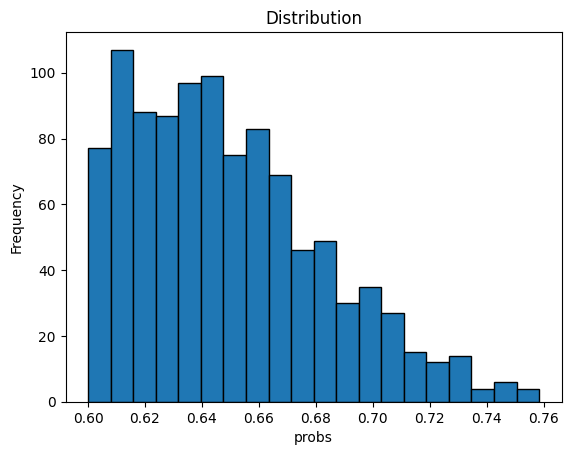

In [250]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# nw template dataset, sold

In [251]:
import random

# List of common, short words which are likely to be single tokens in GPT-2
common_words = [
    "Apple", "Ball", "Car", "Dog", "Egg", "Fish", "Gold", "Hat", "Ink", "Jar",
    "Kite", "Lamp", "Moon", "Nest", "Owl", "Pig", "Quilt", "Rat", "Sun", "Tree",
    "Umbrella", "Vase", "Wolf", "Yarn", "Zip", "Bird", "Cat", "Drum", "Frog",
    "Grape", "House", "Ice", "Juice", "Key", "Leaf", "Map", "Nut", "Orange",
    "Piano", "Queen", "Ring", "Star", "Train", "Van", "Whale", "Xylophone",
    "Yacht", "Zebra", "Ax", "Box", "Cow", "Desk", "Ear", "Fan", "Gate", "Hill",
    "Iron", "Joke", "King", "Lion", "Milk", "Nose", "Oil", "Pen", "Quiz", "Rose",
    "Shoe", "Tail", "Vine", "Wall", "Year", "Ant", "Bug", "Corn", "Duck", "Fire",
    "Grass", "Hand", "Island", "Jam", "Knee", "Lake", "Mouse", "Nail", "Pear",
    "Quack", "Road", "Sand", "Tent", "Valley", "Wind", "Yard", "Arm", "Boat",
    "Cake", "Door", "Eye", "Flag", "Horse", "Jeep", "Knife", "Light", "Mountain",
    "Night", "Ocean", "Plate", "Queen", "Rain", "Snow", "Tree", "Umbrella",
    "Valley", "Window", "Yogurt", "Zoo"
]

In [252]:
# List of various objects for random selection, ensuring each item is a single word
# single_word_objects = [
#     "apple", "ball", "chair", "desk", "elephant", "flower", "guitar", "hat", "jug", "kite",
#     "lamp", "mirror", "orange", "piano", "quilt", "ring", "television", "umbrella", "violin", "watch",
#     "yacht", "zebra", "book", "cup", "drone", "fridge", "gloves", "helmet", "igloo", "jacket",
#     "key", "lemon", "mug", "nail", "octopus", "pillow", "robot", "spoon", "tree", "unicorn",
#     "vase", "wheel", "yo-yo", "zipper", "backpack", "camera", "dumbbell", "envelope", "flashlight", "goggles",
#     "hammer", "ink", "jeans", "ladder", "microphone", "nest", "owl", "penguin", "quill", "ruler",
#     "scissors", "tent", "volcano", "wallet", "yogurt", "zucchini", "accordion", "bicycle", "candle", "dice",
#     "egg", "fan", "grapes", "horseshoe", "ice", "jar", "kettle", "leaf", "mask", "needle",
#     "oar", "peach", "quartz", "record", "saxophone", "toothbrush", "utensils", "vacuum", "wrench", "yarn",
#     "ashtray", "broom", "couch", "duck", "escalator", "figurine", "globe", "harp", "island", "jewel",
#     "kazoo", "lyre", "marble", "notepad", "opera", "pickle", "quartz", "raccoon", "saddle", "tulip"
# ] + [
#         "Balloon", "Bicycle", "Car", "Doll", "Eagle", "Flag", "Giraffe", "Helmet", "Igloo", "Jacket",
#         "Kite", "Lion", "Monkey", "Nest", "Oven", "Pencil", "Quill", "Rabbit", "Star", "Truck",
#         "Umbrella", "Violin", "Whale", "Xylophone", "Yak", "Zebra", "Apple", "Banana", "Camera", "Drum",
#         "Elephant", "Fork", "Glass", "House", "Island", "Jewel", "Kangaroo", "Lamp", "Mountain", "Notebook",
#         "Orange", "Piano", "Queen", "Rose", "Snake", "Tiger", "Urn", "Vase", "Window", "Xerox",
#         "Yoyo", "Zipper", "Anchor", "Brush", "Clock", "Dress", "Easel", "Fan", "Guitar", "Harp",
#         "Ink", "Jug", "Knife", "Leaf", "Mirror", "Nut", "Owl", "Penguin", "Quartz", "Ring",
#         "Spoon", "Table", "Ukulele", "Van", "Watch", "X-ray", "Yarn", "Zucchini", "Artichoke", "Broccoli",
#         "Cup", "Desk", "Egg", "Fridge", "Grape", "Hose", "Iris", "Jackal", "Kettle", "Lizard",
#         "Mango", "Napkin", "Ostrich", "Peacock", "Quokka", "Racoon", "Seal", "Tulip", "Urchin", "Violet"
#     ]

random_single_word_objects = [obj.capitalize() for obj in common_words]

In [253]:
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
random_single_word_objects = filter_to_single_token(random_single_word_objects)
len(random_single_word_objects)

65

In [254]:
def generate_prompts_list(x, y, words):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    month_to_num = {
    'January': 'one', 'February': 'two', 'March': 'three', 'April': 'four', 'May': 'five', 'June': 'six',
    'July': 'seven', 'August': 'eight', 'September': 'nine', 'October': 'ten', 'November': 'eleven', 'December': 'twelve'
    }
    months = [month_to_num[i] for i in months]
    prompts_list = []
    for i in range(x, y):
        # for j in range(20):
        for j in range(1024):
        # for j in range(2):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': months[i],
                'S2': months[i+1],
                'S3': months[i+2],
                'S4': months[i+3],
                'corr': f" {months[i+4]}",
                'incorr': f" {months[i+3]}",
                'text': f"{rand_words[0]} was born in {months[i]}. {rand_words[1]} was born in {months[i+1]}. {rand_words[2]} was born in {months[i+2]}. {rand_words[3]} was born in {months[i+3]}. {rand_words[4]} was born in",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

# "Claire was born in February. John was born in March. Eve was born in April. Bob was born in”
prompts_list = generate_prompts_list(0, 8, names[:100])

In [255]:
prompts_list[5000]

{'S1': 'five',
 'S2': 'six',
 'S3': 'seven',
 'S4': 'eight',
 'corr': ' nine',
 'incorr': ' eight',
 'text': 'Roger was born in five. Kyle was born in six. Frank was born in seven. Sean was born in eight. Kevin was born in'}

In [256]:
example_prompt = prompts_list[5000]['text']
example_answer = prompts_list[5000]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Roger', ' was', ' born', ' in', ' five', '.', ' Kyle', ' was', ' born', ' in', ' six', '.', ' Frank', ' was', ' born', ' in', ' seven', '.', ' Sean', ' was', ' born', ' in', ' eight', '.', ' Kevin', ' was', ' born', ' in']
Tokenized answer: [' nine']


Performance on answer token:
Rank: 0        Logit: 20.72 Prob: 57.32% Token: | nine|

Top 0th token. Logit: 20.72 Prob: 57.32% Token: | nine|
Top 1th token. Logit: 19.73 Prob: 21.32% Token: | ten|
Top 2th token. Logit: 18.47 Prob:  6.06% Token: | eleven|
Top 3th token. Logit: 17.36 Prob:  2.00% Token: | twelve|
Top 4th token. Logit: 17.32 Prob:  1.92% Token: | thirteen|
Top 5th token. Logit: 16.97 Prob:  1.36% Token: | 10|
Top 6th token. Logit: 16.88 Prob:  1.23% Token: | eight|
Top 7th token. Logit: 16.71 Prob:  1.05% Token: | 11|
Top 8th token. Logit: 16.38 Prob:  0.75% Token: | five|
Top 9th token. Logit: 16.31 Prob:  0.70% Token: | twenty|


Ranks of the answer tokens: [(' nine', 0)]

In [258]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.6 and probs[1] < 0.2:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [259]:
import pickle

# Saving the dictionary to a file using pickle
with open('nw_prompts_sold.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('nw_prompts_sold.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [260]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_sold.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Elizabeth was born in one. Guy was born in two. Angel was born in three. Billy was born in four. Edward was born in'}, {'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Ian was born in one. Andrew was born in two. Jeremy was born in three. Laura was born in four. Jason was born in'}, {'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Michael was born in one. Mary was born in two. Blake was born in three. Alexander was born in four. Rose was born in'}, {'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Joseph was born in one. Donald was born in two. Roy was born in three. Christopher was born in four. Patrick was born in'}, {'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Guy was born in

Text(0.5, 1.0, 'Distribution')

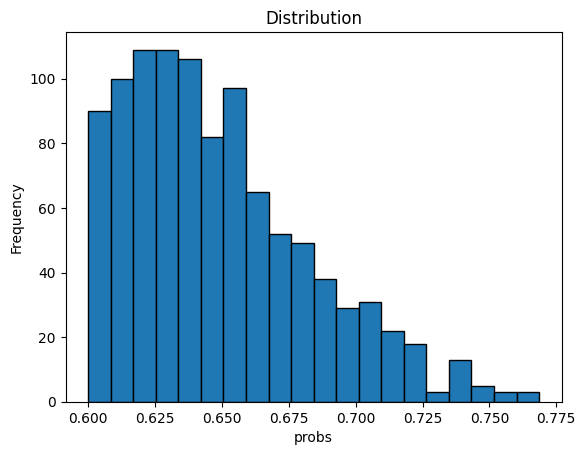

In [261]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# nw template dataset, made

In [262]:
import random

# List of common, short words which are likely to be single tokens in GPT-2
common_words = [
    "Apple", "Ball", "Car", "Dog", "Egg", "Fish", "Gold", "Hat", "Ink", "Jar",
    "Kite", "Lamp", "Moon", "Nest", "Owl", "Pig", "Quilt", "Rat", "Sun", "Tree",
    "Umbrella", "Vase", "Wolf", "Yarn", "Zip", "Bird", "Cat", "Drum", "Frog",
    "Grape", "House", "Ice", "Juice", "Key", "Leaf", "Map", "Nut", "Orange",
    "Piano", "Queen", "Ring", "Star", "Train", "Van", "Whale", "Xylophone",
    "Yacht", "Zebra", "Ax", "Box", "Cow", "Desk", "Ear", "Fan", "Gate", "Hill",
    "Iron", "Joke", "King", "Lion", "Milk", "Nose", "Oil", "Pen", "Quiz", "Rose",
    "Shoe", "Tail", "Vine", "Wall", "Year", "Ant", "Bug", "Corn", "Duck", "Fire",
    "Grass", "Hand", "Island", "Jam", "Knee", "Lake", "Mouse", "Nail", "Pear",
    "Quack", "Road", "Sand", "Tent", "Valley", "Wind", "Yard", "Arm", "Boat",
    "Cake", "Door", "Eye", "Flag", "Horse", "Jeep", "Knife", "Light", "Mountain",
    "Night", "Ocean", "Plate", "Queen", "Rain", "Snow", "Tree", "Umbrella",
    "Valley", "Window", "Yogurt", "Zoo"
]

In [263]:
# List of various objects for random selection, ensuring each item is a single word
# single_word_objects = [
#     "apple", "ball", "chair", "desk", "elephant", "flower", "guitar", "hat", "jug", "kite",
#     "lamp", "mirror", "orange", "piano", "quilt", "ring", "television", "umbrella", "violin", "watch",
#     "yacht", "zebra", "book", "cup", "drone", "fridge", "gloves", "helmet", "igloo", "jacket",
#     "key", "lemon", "mug", "nail", "octopus", "pillow", "robot", "spoon", "tree", "unicorn",
#     "vase", "wheel", "yo-yo", "zipper", "backpack", "camera", "dumbbell", "envelope", "flashlight", "goggles",
#     "hammer", "ink", "jeans", "ladder", "microphone", "nest", "owl", "penguin", "quill", "ruler",
#     "scissors", "tent", "volcano", "wallet", "yogurt", "zucchini", "accordion", "bicycle", "candle", "dice",
#     "egg", "fan", "grapes", "horseshoe", "ice", "jar", "kettle", "leaf", "mask", "needle",
#     "oar", "peach", "quartz", "record", "saxophone", "toothbrush", "utensils", "vacuum", "wrench", "yarn",
#     "ashtray", "broom", "couch", "duck", "escalator", "figurine", "globe", "harp", "island", "jewel",
#     "kazoo", "lyre", "marble", "notepad", "opera", "pickle", "quartz", "raccoon", "saddle", "tulip"
# ] + [
#         "Balloon", "Bicycle", "Car", "Doll", "Eagle", "Flag", "Giraffe", "Helmet", "Igloo", "Jacket",
#         "Kite", "Lion", "Monkey", "Nest", "Oven", "Pencil", "Quill", "Rabbit", "Star", "Truck",
#         "Umbrella", "Violin", "Whale", "Xylophone", "Yak", "Zebra", "Apple", "Banana", "Camera", "Drum",
#         "Elephant", "Fork", "Glass", "House", "Island", "Jewel", "Kangaroo", "Lamp", "Mountain", "Notebook",
#         "Orange", "Piano", "Queen", "Rose", "Snake", "Tiger", "Urn", "Vase", "Window", "Xerox",
#         "Yoyo", "Zipper", "Anchor", "Brush", "Clock", "Dress", "Easel", "Fan", "Guitar", "Harp",
#         "Ink", "Jug", "Knife", "Leaf", "Mirror", "Nut", "Owl", "Penguin", "Quartz", "Ring",
#         "Spoon", "Table", "Ukulele", "Van", "Watch", "X-ray", "Yarn", "Zucchini", "Artichoke", "Broccoli",
#         "Cup", "Desk", "Egg", "Fridge", "Grape", "Hose", "Iris", "Jackal", "Kettle", "Lizard",
#         "Mango", "Napkin", "Ostrich", "Peacock", "Quokka", "Racoon", "Seal", "Tulip", "Urchin", "Violet"
#     ]

random_single_word_objects = [obj.capitalize() for obj in common_words]

In [264]:
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
random_single_word_objects = filter_to_single_token(random_single_word_objects)
len(random_single_word_objects)

65

In [265]:
def generate_prompts_list(x, y, words):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    month_to_num = {
    'January': 'one', 'February': 'two', 'March': 'three', 'April': 'four', 'May': 'five', 'June': 'six',
    'July': 'seven', 'August': 'eight', 'September': 'nine', 'October': 'ten', 'November': 'eleven', 'December': 'twelve'
    }
    months = [month_to_num[i] for i in months]
    prompts_list = []
    for i in range(x, y):
        # for j in range(20):
        for j in range(1024):
        # for j in range(2):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': months[i],
                'S2': months[i+1],
                'S3': months[i+2],
                'S4': months[i+3],
                'corr': f" {months[i+4]}",
                'incorr': f" {months[i+3]}",
                'text': f"{rand_words[0]} was born in {months[i]}. {rand_words[1]} was born in {months[i+1]}. {rand_words[2]} was born in {months[i+2]}. {rand_words[3]} was born in {months[i+3]}. {rand_words[4]} was born in",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

# "Claire was born in February. John was born in March. Eve was born in April. Bob was born in”
prompts_list = generate_prompts_list(0, 8, names[:100])

In [266]:
prompts_list[5000]

{'S1': 'five',
 'S2': 'six',
 'S3': 'seven',
 'S4': 'eight',
 'corr': ' nine',
 'incorr': ' eight',
 'text': 'Hunter was born in five. Mark was born in six. Sarah was born in seven. Donald was born in eight. Connor was born in'}

In [267]:
example_prompt = prompts_list[5000]['text']
example_answer = prompts_list[5000]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Hunter', ' was', ' born', ' in', ' five', '.', ' Mark', ' was', ' born', ' in', ' six', '.', ' Sarah', ' was', ' born', ' in', ' seven', '.', ' Donald', ' was', ' born', ' in', ' eight', '.', ' Connor', ' was', ' born', ' in']
Tokenized answer: [' nine']


Performance on answer token:
Rank: 0        Logit: 21.41 Prob: 62.45% Token: | nine|

Top 0th token. Logit: 21.41 Prob: 62.45% Token: | nine|
Top 1th token. Logit: 20.30 Prob: 20.57% Token: | ten|
Top 2th token. Logit: 18.67 Prob:  4.05% Token: | eleven|
Top 3th token. Logit: 17.87 Prob:  1.80% Token: | eight|
Top 4th token. Logit: 17.64 Prob:  1.44% Token: | twelve|
Top 5th token. Logit: 17.63 Prob:  1.43% Token: | thirteen|
Top 6th token. Logit: 17.37 Prob:  1.10% Token: | 10|
Top 7th token. Logit: 17.16 Prob:  0.89% Token: | five|
Top 8th token. Logit: 16.73 Prob:  0.58% Token: | 11|
Top 9th token. Logit: 16.65 Prob:  0.54% Token: | twenty|


Ranks of the answer tokens: [(' nine', 0)]

In [ ]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.6 and probs[1] < 0.2:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132


In [ ]:
import pickle

# Saving the dictionary to a file using pickle
with open('nw_prompts_made.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('nw_prompts_made.pkl')

In [ ]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_made.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

In [ ]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# months template dataset names

In [67]:
!pip install faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.3 MB/s eta 0:00:00


In [71]:
from faker import Faker
import random

# Initialize Faker
fake = Faker()

# Generate 100 unique first names
first_names = set()
while len(first_names) < 500:
    first_name = fake.first_name()
    first_names.add(first_name)

first_names = list(first_names)
# first_names[:10]  # Display the first 10 names as an example

In [72]:
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
names = filter_to_single_token(first_names)
len(names)

135

In [125]:
def generate_prompts_list(x, y, words):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    prompts_list = []
    for i in range(x, y):
        # for j in range(20):
        for j in range(1024):
        # for j in range(2):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': months[i],
                'S2': months[i+1],
                'S3': months[i+2],
                'S4': months[i+3],
                'corr': f" {months[i+4]}",
                'incorr': f" {months[i+3]}",
                'text': f"{rand_words[0]} was born in {months[i]}. {rand_words[1]} was born in {months[i+1]}. {rand_words[2]} was born in {months[i+2]}. {rand_words[3]} was born in {months[i+3]}. {rand_words[4]} was born in",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

# "Claire was born in February. John was born in March. Eve was born in April. Bob was born in”
prompts_list = generate_prompts_list(0, 8, names[:100])

In [126]:
prompts_list[5000]

{'S1': 'May',
 'S2': 'June',
 'S3': 'July',
 'S4': 'August',
 'corr': ' September',
 'incorr': ' August',
 'text': 'Stephen was born in May. Marie was born in June. Jesus was born in July. Andrew was born in August. Guy was born in'}

In [127]:
example_prompt = prompts_list[5000]['text']
example_answer = prompts_list[5000]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Stephen', ' was', ' born', ' in', ' May', '.', ' Marie', ' was', ' born', ' in', ' June', '.', ' Jesus', ' was', ' born', ' in', ' July', '.', ' Andrew', ' was', ' born', ' in', ' August', '.', ' Guy', ' was', ' born', ' in']
Tokenized answer: [' September']


Performance on answer token:
Rank: 0        Logit: 21.39 Prob: 73.48% Token: | September|

Top 0th token. Logit: 21.39 Prob: 73.48% Token: | September|
Top 1th token. Logit: 19.66 Prob: 12.98% Token: | October|
Top 2th token. Logit: 19.17 Prob:  7.99% Token: | November|
Top 3th token. Logit: 17.60 Prob:  1.66% Token: | December|
Top 4th token. Logit: 17.56 Prob:  1.59% Token: | January|
Top 5th token. Logit: 16.55 Prob:  0.58% Token: | August|
Top 6th token. Logit: 16.16 Prob:  0.39% Token: | March|
Top 7th token. Logit: 15.48 Prob:  0.20% Token: | May|
Top 8th token. Logit: 15.34 Prob:  0.17% Token: | April|
Top 9th token. Logit: 15.00 Prob:  0.12% Token: | July|


Ranks of the answer tokens: [(' September', 0)]

In [128]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.7 and probs[1] < 0.15:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [129]:
import pickle

# Saving the dictionary to a file using pickle
with open('months_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('months_prompts_names.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [86]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'months_prompts_names.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Austin was born in January. Christopher was born in February. Christian was born in March. Aaron was born in April. Madison was born in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Victoria was born in January. Marc was born in February. Patrick was born in March. Leon was born in April. Thomas was born in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Howard was born in January. Mark was born in February. George was born in March. Peter was born in April. Andrew was born in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Kelly was born in January. Victoria was born in February. Austin was born in March. Daniel was born in April. Blake was born in'}, {'S1': 'January', 'S2': 'Fe

Text(0.5, 1.0, 'Distribution')

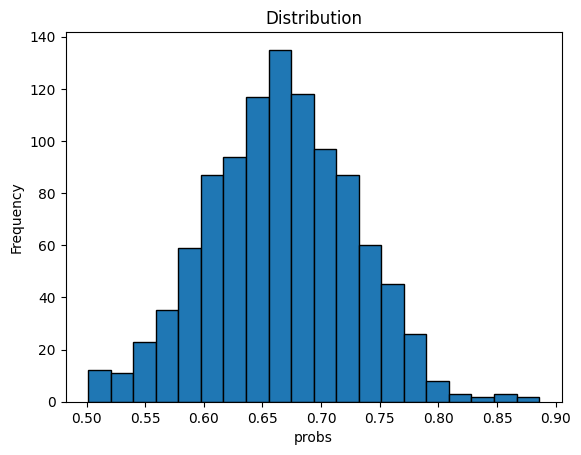

In [88]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# months template dataset, sold

In [189]:
import random

# List of common, short words which are likely to be single tokens in GPT-2
common_words = [
    "Apple", "Ball", "Car", "Dog", "Egg", "Fish", "Gold", "Hat", "Ink", "Jar",
    "Kite", "Lamp", "Moon", "Nest", "Owl", "Pig", "Quilt", "Rat", "Sun", "Tree",
    "Umbrella", "Vase", "Wolf", "Yarn", "Zip", "Bird", "Cat", "Drum", "Frog",
    "Grape", "House", "Ice", "Juice", "Key", "Leaf", "Map", "Nut", "Orange",
    "Piano", "Queen", "Ring", "Star", "Train", "Van", "Whale", "Xylophone",
    "Yacht", "Zebra", "Ax", "Box", "Cow", "Desk", "Ear", "Fan", "Gate", "Hill",
    "Iron", "Joke", "King", "Lion", "Milk", "Nose", "Oil", "Pen", "Quiz", "Rose",
    "Shoe", "Tail", "Vine", "Wall", "Year", "Ant", "Bug", "Corn", "Duck", "Fire",
    "Grass", "Hand", "Island", "Jam", "Knee", "Lake", "Mouse", "Nail", "Pear",
    "Quack", "Road", "Sand", "Tent", "Valley", "Wind", "Yard", "Arm", "Boat",
    "Cake", "Door", "Eye", "Flag", "Horse", "Jeep", "Knife", "Light", "Mountain",
    "Night", "Ocean", "Plate", "Queen", "Rain", "Snow", "Tree", "Umbrella",
    "Valley", "Window", "Yogurt", "Zoo"
]

In [190]:
# List of various objects for random selection, ensuring each item is a single word
# single_word_objects = [
#     "apple", "ball", "chair", "desk", "elephant", "flower", "guitar", "hat", "jug", "kite",
#     "lamp", "mirror", "orange", "piano", "quilt", "ring", "television", "umbrella", "violin", "watch",
#     "yacht", "zebra", "book", "cup", "drone", "fridge", "gloves", "helmet", "igloo", "jacket",
#     "key", "lemon", "mug", "nail", "octopus", "pillow", "robot", "spoon", "tree", "unicorn",
#     "vase", "wheel", "yo-yo", "zipper", "backpack", "camera", "dumbbell", "envelope", "flashlight", "goggles",
#     "hammer", "ink", "jeans", "ladder", "microphone", "nest", "owl", "penguin", "quill", "ruler",
#     "scissors", "tent", "volcano", "wallet", "yogurt", "zucchini", "accordion", "bicycle", "candle", "dice",
#     "egg", "fan", "grapes", "horseshoe", "ice", "jar", "kettle", "leaf", "mask", "needle",
#     "oar", "peach", "quartz", "record", "saxophone", "toothbrush", "utensils", "vacuum", "wrench", "yarn",
#     "ashtray", "broom", "couch", "duck", "escalator", "figurine", "globe", "harp", "island", "jewel",
#     "kazoo", "lyre", "marble", "notepad", "opera", "pickle", "quartz", "raccoon", "saddle", "tulip"
# ] + [
#         "Balloon", "Bicycle", "Car", "Doll", "Eagle", "Flag", "Giraffe", "Helmet", "Igloo", "Jacket",
#         "Kite", "Lion", "Monkey", "Nest", "Oven", "Pencil", "Quill", "Rabbit", "Star", "Truck",
#         "Umbrella", "Violin", "Whale", "Xylophone", "Yak", "Zebra", "Apple", "Banana", "Camera", "Drum",
#         "Elephant", "Fork", "Glass", "House", "Island", "Jewel", "Kangaroo", "Lamp", "Mountain", "Notebook",
#         "Orange", "Piano", "Queen", "Rose", "Snake", "Tiger", "Urn", "Vase", "Window", "Xerox",
#         "Yoyo", "Zipper", "Anchor", "Brush", "Clock", "Dress", "Easel", "Fan", "Guitar", "Harp",
#         "Ink", "Jug", "Knife", "Leaf", "Mirror", "Nut", "Owl", "Penguin", "Quartz", "Ring",
#         "Spoon", "Table", "Ukulele", "Van", "Watch", "X-ray", "Yarn", "Zucchini", "Artichoke", "Broccoli",
#         "Cup", "Desk", "Egg", "Fridge", "Grape", "Hose", "Iris", "Jackal", "Kettle", "Lizard",
#         "Mango", "Napkin", "Ostrich", "Peacock", "Quokka", "Racoon", "Seal", "Tulip", "Urchin", "Violet"
#     ]

random_single_word_objects = [obj.capitalize() for obj in common_words]

In [191]:
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
random_single_word_objects = filter_to_single_token(random_single_word_objects)
len(random_single_word_objects)

65

In [192]:
def generate_prompts_list(x, y, words):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    prompts_list = []
    for i in range(x, y):
        # for j in range(20):
        for j in range(1024):
        # for j in range(2):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': months[i],
                'S2': months[i+1],
                'S3': months[i+2],
                'S4': months[i+3],
                'corr': f" {months[i+4]}",
                'incorr': f" {months[i+3]}",
                'text': f"{rand_words[0]} was sold in {months[i]}. {rand_words[1]} was sold in {months[i+1]}. {rand_words[2]} was sold in {months[i+2]}. {rand_words[3]} was sold in {months[i+3]}. {rand_words[4]} was sold in",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

# "Claire was born in February. John was born in March. Eve was born in April. Bob was born in”
prompts_list = generate_prompts_list(0, 8, random_single_word_objects[:100])

In [193]:
prompts_list[5000]

{'S1': 'May',
 'S2': 'June',
 'S3': 'July',
 'S4': 'August',
 'corr': ' September',
 'incorr': ' August',
 'text': 'Queen was sold in May. Corn was sold in June. Road was sold in July. Ax was sold in August. Car was sold in'}

In [194]:
example_prompt = prompts_list[5000]['text']
example_answer = prompts_list[5000]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Queen', ' was', ' sold', ' in', ' May', '.', ' Corn', ' was', ' sold', ' in', ' June', '.', ' Road', ' was', ' sold', ' in', ' July', '.', ' Ax', ' was', ' sold', ' in', ' August', '.', ' Car', ' was', ' sold', ' in']
Tokenized answer: [' September']


Performance on answer token:
Rank: 0        Logit: 20.95 Prob: 86.12% Token: | September|

Top 0th token. Logit: 20.95 Prob: 86.12% Token: | September|
Top 1th token. Logit: 18.33 Prob:  6.23% Token: | October|
Top 2th token. Logit: 17.74 Prob:  3.47% Token: | November|
Top 3th token. Logit: 16.33 Prob:  0.84% Token: | December|
Top 4th token. Logit: 15.98 Prob:  0.60% Token: | August|
Top 5th token. Logit: 15.77 Prob:  0.48% Token: | January|
Top 6th token. Logit: 15.71 Prob:  0.45% Token: | May|
Top 7th token. Logit: 15.32 Prob:  0.31% Token: | March|
Top 8th token. Logit: 15.02 Prob:  0.23% Token: | early|
Top 9th token. Logit: 14.81 Prob:  0.18% Token: | July|


Ranks of the answer tokens: [(' September', 0)]

In [195]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.7 and probs[1] < 0.1:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [196]:
import pickle

# Saving the dictionary to a file using pickle
with open('months_prompts_sold.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('months_prompts_sold.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [197]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'months_prompts_sold.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Cat was sold in January. Ax was sold in February. Sun was sold in March. Year was sold in April. Ring was sold in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Eye was sold in January. Gate was sold in February. Window was sold in March. Ant was sold in April. Cow was sold in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Fire was sold in January. Cow was sold in February. Rat was sold in March. Rose was sold in April. Tree was sold in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Oil was sold in January. Rain was sold in February. Train was sold in March. Window was sold in April. Snow was sold in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' 

Text(0.5, 1.0, 'Distribution')

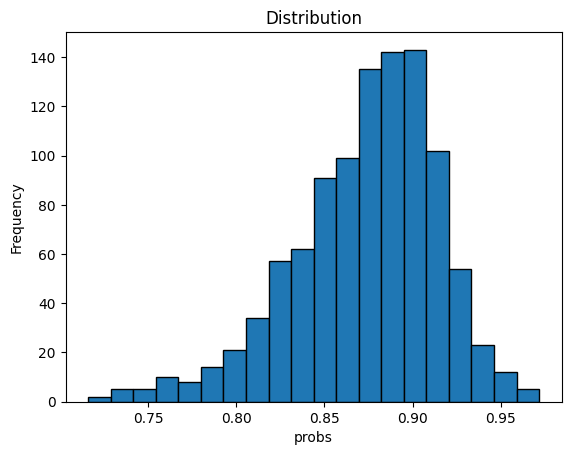

In [198]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# months template dataset, made

In [130]:
import random

# List of common, short words which are likely to be single tokens in GPT-2
common_words = [
    "Apple", "Ball", "Car", "Dog", "Egg", "Fish", "Gold", "Hat", "Ink", "Jar",
    "Kite", "Lamp", "Moon", "Nest", "Owl", "Pig", "Quilt", "Rat", "Sun", "Tree",
    "Umbrella", "Vase", "Wolf", "Yarn", "Zip", "Bird", "Cat", "Drum", "Frog",
    "Grape", "House", "Ice", "Juice", "Key", "Leaf", "Map", "Nut", "Orange",
    "Piano", "Queen", "Ring", "Star", "Train", "Van", "Whale", "Xylophone",
    "Yacht", "Zebra", "Ax", "Box", "Cow", "Desk", "Ear", "Fan", "Gate", "Hill",
    "Iron", "Joke", "King", "Lion", "Milk", "Nose", "Oil", "Pen", "Quiz", "Rose",
    "Shoe", "Tail", "Vine", "Wall", "Year", "Ant", "Bug", "Corn", "Duck", "Fire",
    "Grass", "Hand", "Island", "Jam", "Knee", "Lake", "Mouse", "Nail", "Pear",
    "Quack", "Road", "Sand", "Tent", "Valley", "Wind", "Yard", "Arm", "Boat",
    "Cake", "Door", "Eye", "Flag", "Horse", "Jeep", "Knife", "Light", "Mountain",
    "Night", "Ocean", "Plate", "Queen", "Rain", "Snow", "Tree", "Umbrella",
    "Valley", "Window", "Yogurt", "Zoo"
]

In [131]:
# List of various objects for random selection, ensuring each item is a single word
# single_word_objects = [
#     "apple", "ball", "chair", "desk", "elephant", "flower", "guitar", "hat", "jug", "kite",
#     "lamp", "mirror", "orange", "piano", "quilt", "ring", "television", "umbrella", "violin", "watch",
#     "yacht", "zebra", "book", "cup", "drone", "fridge", "gloves", "helmet", "igloo", "jacket",
#     "key", "lemon", "mug", "nail", "octopus", "pillow", "robot", "spoon", "tree", "unicorn",
#     "vase", "wheel", "yo-yo", "zipper", "backpack", "camera", "dumbbell", "envelope", "flashlight", "goggles",
#     "hammer", "ink", "jeans", "ladder", "microphone", "nest", "owl", "penguin", "quill", "ruler",
#     "scissors", "tent", "volcano", "wallet", "yogurt", "zucchini", "accordion", "bicycle", "candle", "dice",
#     "egg", "fan", "grapes", "horseshoe", "ice", "jar", "kettle", "leaf", "mask", "needle",
#     "oar", "peach", "quartz", "record", "saxophone", "toothbrush", "utensils", "vacuum", "wrench", "yarn",
#     "ashtray", "broom", "couch", "duck", "escalator", "figurine", "globe", "harp", "island", "jewel",
#     "kazoo", "lyre", "marble", "notepad", "opera", "pickle", "quartz", "raccoon", "saddle", "tulip"
# ] + [
#         "Balloon", "Bicycle", "Car", "Doll", "Eagle", "Flag", "Giraffe", "Helmet", "Igloo", "Jacket",
#         "Kite", "Lion", "Monkey", "Nest", "Oven", "Pencil", "Quill", "Rabbit", "Star", "Truck",
#         "Umbrella", "Violin", "Whale", "Xylophone", "Yak", "Zebra", "Apple", "Banana", "Camera", "Drum",
#         "Elephant", "Fork", "Glass", "House", "Island", "Jewel", "Kangaroo", "Lamp", "Mountain", "Notebook",
#         "Orange", "Piano", "Queen", "Rose", "Snake", "Tiger", "Urn", "Vase", "Window", "Xerox",
#         "Yoyo", "Zipper", "Anchor", "Brush", "Clock", "Dress", "Easel", "Fan", "Guitar", "Harp",
#         "Ink", "Jug", "Knife", "Leaf", "Mirror", "Nut", "Owl", "Penguin", "Quartz", "Ring",
#         "Spoon", "Table", "Ukulele", "Van", "Watch", "X-ray", "Yarn", "Zucchini", "Artichoke", "Broccoli",
#         "Cup", "Desk", "Egg", "Fridge", "Grape", "Hose", "Iris", "Jackal", "Kettle", "Lizard",
#         "Mango", "Napkin", "Ostrich", "Peacock", "Quokka", "Racoon", "Seal", "Tulip", "Urchin", "Violet"
#     ]

random_single_word_objects = [obj.capitalize() for obj in common_words]

In [132]:
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
random_single_word_objects = filter_to_single_token(random_single_word_objects)
len(random_single_word_objects)

65

In [133]:
def generate_prompts_list(x, y, words):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    prompts_list = []
    for i in range(x, y):
        # for j in range(20):
        for j in range(1024):
        # for j in range(2):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': months[i],
                'S2': months[i+1],
                'S3': months[i+2],
                'S4': months[i+3],
                'corr': f" {months[i+4]}",
                'incorr': f" {months[i+3]}",
                'text': f"{rand_words[0]} was made in {months[i]}. {rand_words[1]} was made in {months[i+1]}. {rand_words[2]} was made in {months[i+2]}. {rand_words[3]} was made in {months[i+3]}. {rand_words[4]} was made in",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

# "Claire was born in February. John was born in March. Eve was born in April. Bob was born in”
prompts_list = generate_prompts_list(0, 8, random_single_word_objects[:100])

In [134]:
prompts_list[5000]

{'S1': 'May',
 'S2': 'June',
 'S3': 'July',
 'S4': 'August',
 'corr': ' September',
 'incorr': ' August',
 'text': 'Zip was made in May. Pear was made in June. Fish was made in July. Arm was made in August. Cat was made in'}

In [135]:
example_prompt = prompts_list[5000]['text']
example_answer = prompts_list[5000]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Zip', ' was', ' made', ' in', ' May', '.', ' Pear', ' was', ' made', ' in', ' June', '.', ' Fish', ' was', ' made', ' in', ' July', '.', ' Arm', ' was', ' made', ' in', ' August', '.', ' Cat', ' was', ' made', ' in']
Tokenized answer: [' September']


Performance on answer token:
Rank: 0        Logit: 21.18 Prob: 91.31% Token: | September|

Top 0th token. Logit: 21.18 Prob: 91.31% Token: | September|
Top 1th token. Logit: 18.17 Prob:  4.51% Token: | October|
Top 2th token. Logit: 17.29 Prob:  1.87% Token: | November|
Top 3th token. Logit: 15.95 Prob:  0.49% Token: | August|
Top 4th token. Logit: 15.92 Prob:  0.48% Token: | December|
Top 5th token. Logit: 15.55 Prob:  0.33% Token: | January|
Top 6th token. Logit: 14.91 Prob:  0.17% Token: | Sept|
Top 7th token. Logit: 14.55 Prob:  0.12% Token: | May|
Top 8th token. Logit: 14.53 Prob:  0.12% Token: | July|
Top 9th token. Logit: 14.45 Prob:  0.11% Token: | March|


Ranks of the answer tokens: [(' September', 0)]

In [136]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.7 and probs[1] < 0.1:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [137]:
import pickle

# Saving the dictionary to a file using pickle
with open('months_prompts_made.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('months_prompts_made.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [138]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'months_prompts_made.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Sand was made in January. Fire was made in February. Bug was made in March. Hat was made in April. Light was made in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Snow was made in January. Gate was made in February. Queen was made in March. Cow was made in April. Jar was made in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Hand was made in January. Queen was made in February. Wind was made in March. Flag was made in April. Night was made in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'King was made in January. Rain was made in February. Dog was made in March. Ring was made in April. Desk was made in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr'

Text(0.5, 1.0, 'Distribution')

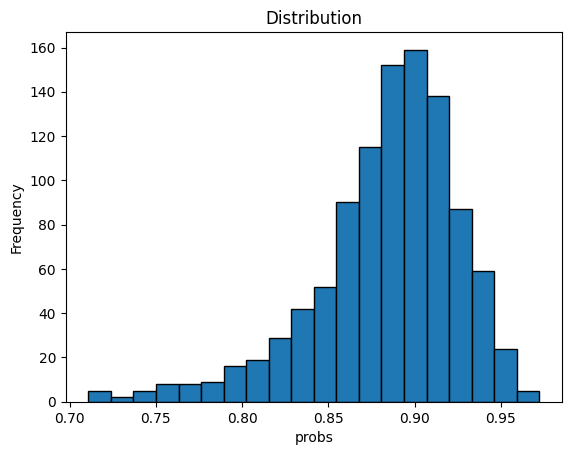

In [139]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# digits template dataset, sold

In [199]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'months_prompts_sold.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list)

[{'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Cat was sold in January. Ax was sold in February. Sun was sold in March. Year was sold in April. Ring was sold in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Eye was sold in January. Gate was sold in February. Window was sold in March. Ant was sold in April. Cow was sold in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Fire was sold in January. Cow was sold in February. Rat was sold in March. Rose was sold in April. Tree was sold in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Oil was sold in January. Rain was sold in February. Train was sold in March. Window was sold in April. Snow was sold in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' 

In [200]:
month_to_num = {
    'January': '1', 'February': '2', 'March': '3', 'April': '4', 'May': '5', 'June': '6',
    'July': '7', 'August': '8', 'September': '9', 'October': '10', 'November': '11', 'December': '12'
}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    for item in data_list:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return data_list

# Replace the month names in the data
prompts_list = replace_month_names(prompts_list)
prompts_list

[{'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Cat was sold in 1. Ax was sold in 2. Sun was sold in 3. Year was sold in 4. Ring was sold in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Eye was sold in 1. Gate was sold in 2. Window was sold in 3. Ant was sold in 4. Cow was sold in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Fire was sold in 1. Cow was sold in 2. Rat was sold in 3. Rose was sold in 4. Tree was sold in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Oil was sold in 1. Rain was sold in 2. Train was sold in 3. Window was sold in 4. Snow was sold in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Box was sold in 1. Cat was sold in 2. Iron was sold in 3. Sun was sold in 4. Fan was sold in'},
 {'S1': '1',
  'S2': '2'

In [201]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' was', ' sold', ' in', ' 1', '.', ' Ice', ' was', ' sold', ' in', ' 2', '.', ' Fire', ' was', ' sold', ' in', ' 3', '.', ' Ear', ' was', ' sold', ' in', ' 4', '.', ' Ocean', ' was', ' sold', ' in']
Tokenized answer: [' 5']


Performance on answer token:
Rank: 0        Logit: 18.47 Prob: 95.14% Token: | 5|

Top 0th token. Logit: 18.47 Prob: 95.14% Token: | 5|
Top 1th token. Logit: 14.50 Prob:  1.79% Token: | 6|
Top 2th token. Logit: 13.43 Prob:  0.61% Token: | 1|
Top 3th token. Logit: 12.97 Prob:  0.39% Token: | 7|
Top 4th token. Logit: 12.81 Prob:  0.33% Token: | 4|
Top 5th token. Logit: 12.30 Prob:  0.20% Token: | 3|
Top 6th token. Logit: 12.11 Prob:  0.17% Token: |
|
Top 7th token. Logit: 11.62 Prob:  0.10% Token: | 10|
Top 8th token. Logit: 11.45 Prob:  0.09% Token: | 2|
Top 9th token. Logit: 11.12 Prob:  0.06% Token: | 9|


Ranks of the answer tokens: [(' 5', 0)]

In [202]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.7 and probs[1] < 0.1:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [203]:
import pickle

# Saving the dictionary to a file using pickle
with open('digits_prompts_sold.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('digits_prompts_sold.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [204]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'digits_prompts_sold.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Cat was sold in 1. Ax was sold in 2. Sun was sold in 3. Year was sold in 4. Ring was sold in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Eye was sold in 1. Gate was sold in 2. Window was sold in 3. Ant was sold in 4. Cow was sold in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Fire was sold in 1. Cow was sold in 2. Rat was sold in 3. Rose was sold in 4. Tree was sold in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Oil was sold in 1. Rain was sold in 2. Train was sold in 3. Window was sold in 4. Snow was sold in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Box was sold in 1. Cat was sold in 2. Iron was sold in 3. Sun was sold in 4. Fan was sold in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Fire

Text(0.5, 1.0, 'Distribution')

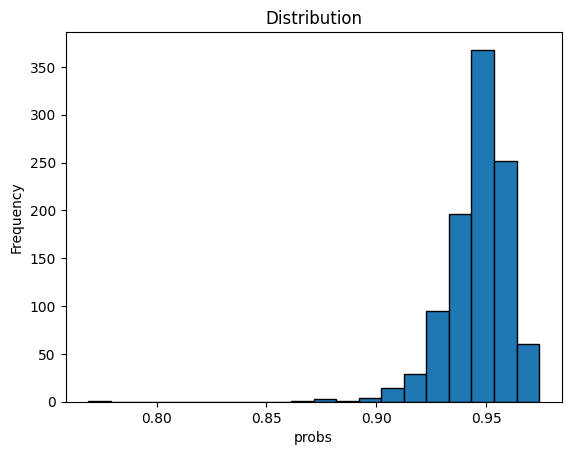

In [205]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# digits template dataset, names

In [182]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'months_prompts_names.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list)

[{'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Rose was born in January. Jesus was born in February. Jean was born in March. Anna was born in April. Alexander was born in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Tim was born in January. Blake was born in February. Billy was born in March. Jason was born in April. Neil was born in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Hunter was born in January. Fred was born in February. Mark was born in March. Christopher was born in April. Sean was born in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Mary was born in January. Larry was born in February. Steve was born in March. Joseph was born in April. Jason was born in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March'

In [183]:
month_to_num = {
    'January': '1', 'February': '2', 'March': '3', 'April': '4', 'May': '5', 'June': '6',
    'July': '7', 'August': '8', 'September': '9', 'October': '10', 'November': '11', 'December': '12'
}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    for item in data_list:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return data_list

# Replace the month names in the data
prompts_list = replace_month_names(prompts_list)
prompts_list

[{'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Rose was born in 1. Jesus was born in 2. Jean was born in 3. Anna was born in 4. Alexander was born in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Tim was born in 1. Blake was born in 2. Billy was born in 3. Jason was born in 4. Neil was born in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Hunter was born in 1. Fred was born in 2. Mark was born in 3. Christopher was born in 4. Sean was born in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Mary was born in 1. Larry was born in 2. Steve was born in 3. Joseph was born in 4. Jason was born in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Neil was born in 1. Steve was born in 2. Jean was born in 3. Bruce was born in 4. Carl was bo

In [184]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Joseph', ' was', ' born', ' in', ' 2', '.', ' Michael', ' was', ' born', ' in', ' 3', '.', ' Charles', ' was', ' born', ' in', ' 4', '.', ' Danny', ' was', ' born', ' in', ' 5', '.', ' Kelly', ' was', ' born', ' in']
Tokenized answer: [' 6']


Performance on answer token:
Rank: 0        Logit: 20.84 Prob: 97.64% Token: | 6|

Top 0th token. Logit: 20.84 Prob: 97.64% Token: | 6|
Top 1th token. Logit: 16.31 Prob:  1.06% Token: | 7|
Top 2th token. Logit: 15.06 Prob:  0.30% Token: | 8|
Top 3th token. Logit: 14.77 Prob:  0.23% Token: | 5|
Top 4th token. Logit: 13.82 Prob:  0.09% Token: | 10|
Top 5th token. Logit: 13.71 Prob:  0.08% Token: | 1|
Top 6th token. Logit: 13.63 Prob:  0.07% Token: | 4|
Top 7th token. Logit: 13.62 Prob:  0.07% Token: | 11|
Top 8th token. Logit: 13.61 Prob:  0.07% Token: | 9|
Top 9th token. Logit: 13.18 Prob:  0.05% Token: | six|


Ranks of the answer tokens: [(' 6', 0)]

In [185]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.7 and probs[1] < 0.1:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [186]:
import pickle

# Saving the dictionary to a file using pickle
with open('digits_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('digits_prompts_names.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [187]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'digits_prompts_names.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Rose was born in 1. Jesus was born in 2. Jean was born in 3. Anna was born in 4. Alexander was born in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Tim was born in 1. Blake was born in 2. Billy was born in 3. Jason was born in 4. Neil was born in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Hunter was born in 1. Fred was born in 2. Mark was born in 3. Christopher was born in 4. Sean was born in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Mary was born in 1. Larry was born in 2. Steve was born in 3. Joseph was born in 4. Jason was born in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Neil was born in 1. Steve was born in 2. Jean was born in 3. Bruce was born in 4. Carl was born in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 

Text(0.5, 1.0, 'Distribution')

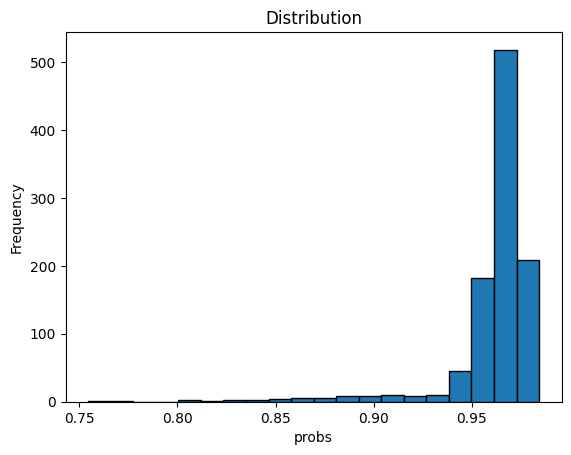

In [188]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# digits template dataset, made

In [ ]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'months_prompts_made.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list)

[{'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Sand was made in January. Fire was made in February. Bug was made in March. Hat was made in April. Light was made in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Snow was made in January. Gate was made in February. Queen was made in March. Cow was made in April. Jar was made in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Hand was made in January. Queen was made in February. Wind was made in March. Flag was made in April. Night was made in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'King was made in January. Rain was made in February. Dog was made in March. Ring was made in April. Desk was made in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr'

In [ ]:
month_to_num = {
    'January': '1', 'February': '2', 'March': '3', 'April': '4', 'May': '5', 'June': '6',
    'July': '7', 'August': '8', 'September': '9', 'October': '10', 'November': '11', 'December': '12'
}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    for item in data_list:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return data_list

# Replace the month names in the data
prompts_list = replace_month_names(prompts_list)
prompts_list

[{'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Sand was made in 1. Fire was made in 2. Bug was made in 3. Hat was made in 4. Light was made in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Snow was made in 1. Gate was made in 2. Queen was made in 3. Cow was made in 4. Jar was made in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Hand was made in 1. Queen was made in 2. Wind was made in 3. Flag was made in 4. Night was made in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'King was made in 1. Rain was made in 2. Dog was made in 3. Ring was made in 4. Desk was made in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Night was made in 1. Key was made in 2. Cow was made in 3. Zip was made in 4. Jam was made in'},
 {'S1': '1',
  'S2'

In [ ]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Flag', ' was', ' made', ' in', ' 1', '.', ' Queen', ' was', ' made', ' in', ' 2', '.', ' Lake', ' was', ' made', ' in', ' 3', '.', ' Rain', ' was', ' made', ' in', ' 4', '.', ' Iron', ' was', ' made', ' in']
Tokenized answer: [' 5']


Performance on answer token:
Rank: 0        Logit: 18.09 Prob: 95.62% Token: | 5|

Top 0th token. Logit: 18.09 Prob: 95.62% Token: | 5|
Top 1th token. Logit: 13.67 Prob:  1.15% Token: | 6|
Top 2th token. Logit: 12.70 Prob:  0.44% Token: | 4|
Top 3th token. Logit: 12.49 Prob:  0.35% Token: | 1|
Top 4th token. Logit: 12.32 Prob:  0.30% Token: | 7|
Top 5th token. Logit: 11.93 Prob:  0.20% Token: | 3|
Top 6th token. Logit: 11.50 Prob:  0.13% Token: | 10|
Top 7th token. Logit: 11.48 Prob:  0.13% Token: |
|
Top 8th token. Logit: 10.86 Prob:  0.07% Token: |5|
Top 9th token. Logit: 10.80 Prob:  0.07% Token: | 2|


Ranks of the answer tokens: [(' 5', 0)]

In [ ]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.7 and probs[1] < 0.1:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
import pickle

# Saving the dictionary to a file using pickle
with open('digits_prompts_made.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('digits_prompts_made.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'digits_prompts_made.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Sand was made in 1. Fire was made in 2. Bug was made in 3. Hat was made in 4. Light was made in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Snow was made in 1. Gate was made in 2. Queen was made in 3. Cow was made in 4. Jar was made in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Hand was made in 1. Queen was made in 2. Wind was made in 3. Flag was made in 4. Night was made in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'King was made in 1. Rain was made in 2. Dog was made in 3. Ring was made in 4. Desk was made in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Night was made in 1. Key was made in 2. Cow was made in 3. Zip was made in 4. Jam was made in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 

Text(0.5, 1.0, 'Distribution')

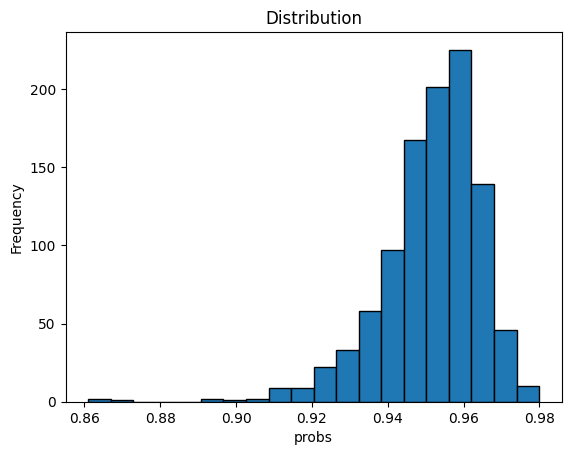

In [ ]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# nw template dataset, sold

In [234]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'months_prompts_sold.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list)

[{'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Cat was sold in January. Ax was sold in February. Sun was sold in March. Year was sold in April. Ring was sold in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Eye was sold in January. Gate was sold in February. Window was sold in March. Ant was sold in April. Cow was sold in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Fire was sold in January. Cow was sold in February. Rat was sold in March. Rose was sold in April. Tree was sold in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Oil was sold in January. Rain was sold in February. Train was sold in March. Window was sold in April. Snow was sold in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' 

In [235]:
month_to_num = {
    'January': 'one', 'February': 'two', 'March': 'three', 'April': 'four', 'May': 'five', 'June': 'six',
    'July': 'seven', 'August': 'eight', 'September': 'nine', 'October': 'ten', 'November': 'eleven', 'December': 'twelve'
}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    for item in data_list:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return data_list

# Replace the month names in the data
prompts_list = replace_month_names(prompts_list)
prompts_list

[{'S1': 'one',
  'S2': 'two',
  'S3': 'three',
  'S4': 'four',
  'corr': ' five',
  'incorr': ' four',
  'text': 'Cat was sold in one. Ax was sold in two. Sun was sold in three. Year was sold in four. Ring was sold in'},
 {'S1': 'one',
  'S2': 'two',
  'S3': 'three',
  'S4': 'four',
  'corr': ' five',
  'incorr': ' four',
  'text': 'Eye was sold in one. Gate was sold in two. Window was sold in three. Ant was sold in four. Cow was sold in'},
 {'S1': 'one',
  'S2': 'two',
  'S3': 'three',
  'S4': 'four',
  'corr': ' five',
  'incorr': ' four',
  'text': 'Fire was sold in one. Cow was sold in two. Rat was sold in three. Rose was sold in four. Tree was sold in'},
 {'S1': 'one',
  'S2': 'two',
  'S3': 'three',
  'S4': 'four',
  'corr': ' five',
  'incorr': ' four',
  'text': 'Oil was sold in one. Rain was sold in two. Train was sold in three. Window was sold in four. Snow was sold in'},
 {'S1': 'one',
  'S2': 'two',
  'S3': 'three',
  'S4': 'four',
  'corr': ' five',
  'incorr': ' four',
  

In [236]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' was', ' sold', ' in', ' one', '.', ' Ice', ' was', ' sold', ' in', ' two', '.', ' Fire', ' was', ' sold', ' in', ' three', '.', ' Ear', ' was', ' sold', ' in', ' four', '.', ' Ocean', ' was', ' sold', ' in']
Tokenized answer: [' five']


Performance on answer token:
Rank: 0        Logit: 20.24 Prob: 53.76% Token: | five|

Top 0th token. Logit: 20.24 Prob: 53.76% Token: | five|
Top 1th token. Logit: 19.19 Prob: 18.78% Token: | six|
Top 2th token. Logit: 18.58 Prob: 10.16% Token: | seven|
Top 3th token. Logit: 17.47 Prob:  3.36% Token: | eight|
Top 4th token. Logit: 17.38 Prob:  3.08% Token: | four|
Top 5th token. Logit: 17.06 Prob:  2.24% Token: | ten|
Top 6th token. Logit: 16.65 Prob:  1.48% Token: | three|
Top 7th token. Logit: 16.44 Prob:  1.19% Token: | nine|
Top 8th token. Logit: 16.34 Prob:  1.08% Token: | one|
Top 9th token. Logit: 15.92 Prob:  0.71% Token: | two|


Ranks of the answer tokens: [(' five', 0)]

In [237]:
prompts_list[510]['text']

'House was sold in one. Ice was sold in two. Fire was sold in three. Ear was sold in four. Ocean was sold in'

In [238]:
logit_diffs = []
all_probs = []
good_prompts = []

minFirst = 101
maxSec = 0
for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )

    if probs[0].item() < minFirst:
        minFirst = probs[0].item()
    if probs[1].item() > maxSec:
        maxSec = probs[1].item()

    # if incor_ind == 'cont':
    #     continue

    # # print(f"{prompt} -> {answer}")
    # # print(probs[0].item(), probs[1].item())
    # if toks[0] == answer and probs[0] > 0.35 and probs[1] < 0.35:
    # # if toks[0] == answer:
    #     # print('good')
    #     all_probs.append(probs)
    #     print(len(good_prompts))
    #     # incor_ind = toks.index(incor)
    #     l_diff = logs[0] - logs[incor_ind]
    #     logit_diffs.append(l_diff.item())
    #     # print(l_diff.item())
    #     good_prompts.append(prompt_dict)
    #     if len(good_prompts) == 1024:
    #         break

In [239]:
print(minFirst)
print(maxSec)

0.2994566261768341
0.2470647245645523


In [ ]:
import pickle

# Saving the dictionary to a file using pickle
with open('nw_prompts_sold.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('nw_prompts_sold.pkl')

In [ ]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_sold.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

In [ ]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# digits template dataset, names

In [ ]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'months_prompts_names.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list)

[{'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Rose was born in January. Jesus was born in February. Jean was born in March. Anna was born in April. Alexander was born in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Tim was born in January. Blake was born in February. Billy was born in March. Jason was born in April. Neil was born in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Hunter was born in January. Fred was born in February. Mark was born in March. Christopher was born in April. Sean was born in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Mary was born in January. Larry was born in February. Steve was born in March. Joseph was born in April. Jason was born in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March'

In [ ]:
month_to_num = {
    'January': '1', 'February': '2', 'March': '3', 'April': '4', 'May': '5', 'June': '6',
    'July': '7', 'August': '8', 'September': '9', 'October': '10', 'November': '11', 'December': '12'
}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    for item in data_list:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return data_list

# Replace the month names in the data
prompts_list = replace_month_names(prompts_list)
prompts_list

[{'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Rose was born in 1. Jesus was born in 2. Jean was born in 3. Anna was born in 4. Alexander was born in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Tim was born in 1. Blake was born in 2. Billy was born in 3. Jason was born in 4. Neil was born in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Hunter was born in 1. Fred was born in 2. Mark was born in 3. Christopher was born in 4. Sean was born in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Mary was born in 1. Larry was born in 2. Steve was born in 3. Joseph was born in 4. Jason was born in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Neil was born in 1. Steve was born in 2. Jean was born in 3. Bruce was born in 4. Carl was bo

In [ ]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Joseph', ' was', ' born', ' in', ' 2', '.', ' Michael', ' was', ' born', ' in', ' 3', '.', ' Charles', ' was', ' born', ' in', ' 4', '.', ' Danny', ' was', ' born', ' in', ' 5', '.', ' Kelly', ' was', ' born', ' in']
Tokenized answer: [' 6']


Performance on answer token:
Rank: 0        Logit: 20.84 Prob: 97.64% Token: | 6|

Top 0th token. Logit: 20.84 Prob: 97.64% Token: | 6|
Top 1th token. Logit: 16.31 Prob:  1.06% Token: | 7|
Top 2th token. Logit: 15.06 Prob:  0.30% Token: | 8|
Top 3th token. Logit: 14.77 Prob:  0.23% Token: | 5|
Top 4th token. Logit: 13.82 Prob:  0.09% Token: | 10|
Top 5th token. Logit: 13.71 Prob:  0.08% Token: | 1|
Top 6th token. Logit: 13.63 Prob:  0.07% Token: | 4|
Top 7th token. Logit: 13.62 Prob:  0.07% Token: | 11|
Top 8th token. Logit: 13.61 Prob:  0.07% Token: | 9|
Top 9th token. Logit: 13.18 Prob:  0.05% Token: | six|


Ranks of the answer tokens: [(' 6', 0)]

In [ ]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.7 and probs[1] < 0.1:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
import pickle

# Saving the dictionary to a file using pickle
with open('digits_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('digits_prompts_names.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'digits_prompts_names.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Rose was born in 1. Jesus was born in 2. Jean was born in 3. Anna was born in 4. Alexander was born in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Tim was born in 1. Blake was born in 2. Billy was born in 3. Jason was born in 4. Neil was born in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Hunter was born in 1. Fred was born in 2. Mark was born in 3. Christopher was born in 4. Sean was born in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Mary was born in 1. Larry was born in 2. Steve was born in 3. Joseph was born in 4. Jason was born in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Neil was born in 1. Steve was born in 2. Jean was born in 3. Bruce was born in 4. Carl was born in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 

Text(0.5, 1.0, 'Distribution')

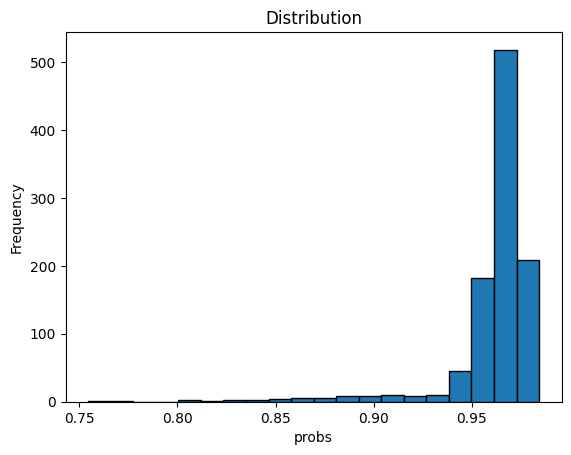

In [ ]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# digits template dataset, made

In [ ]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'months_prompts_made.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list)

[{'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Sand was made in January. Fire was made in February. Bug was made in March. Hat was made in April. Light was made in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Snow was made in January. Gate was made in February. Queen was made in March. Cow was made in April. Jar was made in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Hand was made in January. Queen was made in February. Wind was made in March. Flag was made in April. Night was made in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'King was made in January. Rain was made in February. Dog was made in March. Ring was made in April. Desk was made in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr'

In [ ]:
month_to_num = {
    'January': '1', 'February': '2', 'March': '3', 'April': '4', 'May': '5', 'June': '6',
    'July': '7', 'August': '8', 'September': '9', 'October': '10', 'November': '11', 'December': '12'
}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    for item in data_list:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return data_list

# Replace the month names in the data
prompts_list = replace_month_names(prompts_list)
prompts_list

[{'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Sand was made in 1. Fire was made in 2. Bug was made in 3. Hat was made in 4. Light was made in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Snow was made in 1. Gate was made in 2. Queen was made in 3. Cow was made in 4. Jar was made in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Hand was made in 1. Queen was made in 2. Wind was made in 3. Flag was made in 4. Night was made in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'King was made in 1. Rain was made in 2. Dog was made in 3. Ring was made in 4. Desk was made in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Night was made in 1. Key was made in 2. Cow was made in 3. Zip was made in 4. Jam was made in'},
 {'S1': '1',
  'S2'

In [ ]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Flag', ' was', ' made', ' in', ' 1', '.', ' Queen', ' was', ' made', ' in', ' 2', '.', ' Lake', ' was', ' made', ' in', ' 3', '.', ' Rain', ' was', ' made', ' in', ' 4', '.', ' Iron', ' was', ' made', ' in']
Tokenized answer: [' 5']


Performance on answer token:
Rank: 0        Logit: 18.09 Prob: 95.62% Token: | 5|

Top 0th token. Logit: 18.09 Prob: 95.62% Token: | 5|
Top 1th token. Logit: 13.67 Prob:  1.15% Token: | 6|
Top 2th token. Logit: 12.70 Prob:  0.44% Token: | 4|
Top 3th token. Logit: 12.49 Prob:  0.35% Token: | 1|
Top 4th token. Logit: 12.32 Prob:  0.30% Token: | 7|
Top 5th token. Logit: 11.93 Prob:  0.20% Token: | 3|
Top 6th token. Logit: 11.50 Prob:  0.13% Token: | 10|
Top 7th token. Logit: 11.48 Prob:  0.13% Token: |
|
Top 8th token. Logit: 10.86 Prob:  0.07% Token: |5|
Top 9th token. Logit: 10.80 Prob:  0.07% Token: | 2|


Ranks of the answer tokens: [(' 5', 0)]

In [ ]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.7 and probs[1] < 0.1:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
import pickle

# Saving the dictionary to a file using pickle
with open('digits_prompts_made.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('digits_prompts_made.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'digits_prompts_made.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Sand was made in 1. Fire was made in 2. Bug was made in 3. Hat was made in 4. Light was made in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Snow was made in 1. Gate was made in 2. Queen was made in 3. Cow was made in 4. Jar was made in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Hand was made in 1. Queen was made in 2. Wind was made in 3. Flag was made in 4. Night was made in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'King was made in 1. Rain was made in 2. Dog was made in 3. Ring was made in 4. Desk was made in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Night was made in 1. Key was made in 2. Cow was made in 3. Zip was made in 4. Jam was made in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 

Text(0.5, 1.0, 'Distribution')

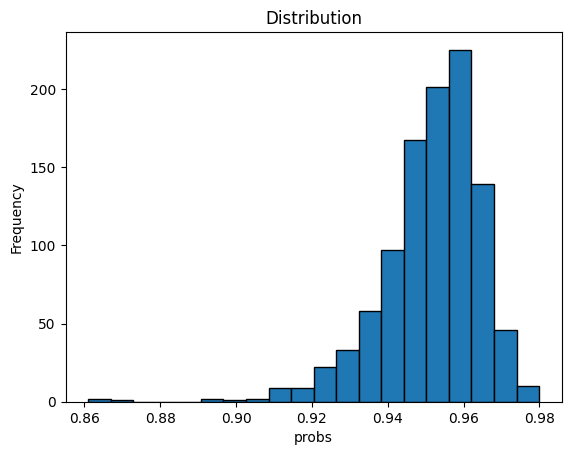

In [ ]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')